In [1]:
%load_ext autoreload 
%autoreload 2

# TODO: 

In order of priority 


-!! explore *lower cutoff* - allow discarding translations beyond a threshold (as their trarget mustbe extremely small)- max_shift <=kgrid
- rhoij computation is slow

- Dimennsionality reduction  

- why are the features for molecular C2 different from the features in 0,0,0, cell (check gij again - probably stupid)



DONE 
- CHECK the band structures - also for the c2 -174 (8,8,1 - pyscf, AIMS)
  
- learn def2-svp (does it consstently get errors on specifc btype, lambda blocks)

- learn hex, predict hex 22 

- learn rotated structures 

# BEGIN

In [2]:
import numpy as np 
import torch 
import metatensor 
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.features.acdc import *
from mlelec.features.acdc_utils import *    
from ase.io import read
from mlelec.utils.twocenter_utils import fix_orbital_order
from ase.visualize import view

torch.set_default_dtype(torch.float64)

/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [27]:
kfock.shape

(19, 64, 10, 10)

In [29]:
frames = read('examples/data/periodic/{}/C2_174.xyz'.format(filename), ':24')
kfock = {name: np.load('examples/data/periodic/c2/results_C2_174_881/fock_{}_{881}.npy')) }

# stupid_frames = 
print(frames[3].positions -  frames[6].positions)
print(frames[3].cell - frames[6].cell)


NameError: name 'SYSTEM' is not defined

In [58]:
import seekpath

In [3]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]}
           }

In [29]:

filename = "graphene_supercell_variety"
names = ['ortho', 'hex', 'double_hex', 'triple_hex', 'hex23']
systemext = {"def2svp": "_def2",
          "large_kgrid": ""}

# ORBS = "def2svp"
# SYSTEM = "def2svp"

ORBS = "sto-3g"
SYSTEM = "large_kgrid"


START= 1
STOP = 3

frames = read('examples/data/periodic/{}/graphene_variety.xyz'.format(filename), slice(START,STOP))
# kspacing = 0.5
# kmesh = [[np.int32(np.max([1, np.ceil(2*np.pi*np.linalg.norm(vec)/kspacing)])) for vec in frame.cell.reciprocal().array] for frame in frames]
kmesh = [[8,8,1], [4,4,1]]

for f in frames:
    f.pbc = [True, True, True]

kfock = {name: np.load('examples/data/periodic/{}/{}/fock_{}_{}{}.npy'.format(filename,SYSTEM,name, ''.join(map(str, kmesh[i])),  systemext[SYSTEM])) for i,name in enumerate(names[START:STOP])}
kover = {name: np.load('examples/data/periodic/{}/{}/over_{}_{}{}.npy'.format(filename,SYSTEM, name, ''.join(map(str, kmesh[i])), systemext[SYSTEM])) for i,name in enumerate(names[START:STOP])}


dataset = {name: PySCFPeriodicDataset(frames = [frames[i]], kgrid=kmesh[i], matrices_kpoint = kfock[name].reshape(1, *kfock[name].shape), overlap_kpoint = kover[name].reshape(1, *kfock[name].shape), target=["real_translation"] ,device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS) for i,name in enumerate(names[START:STOP])}

# for name in dataset: 
#     for T in dataset[name].matrices_translation: 
#         dataset[name].matrices_translation[T] = fix_orbital_order(dataset[name].matrices_translation[T], dataset[name].structures, dataset[name].basis)


In [5]:
filename = "c2"
ORBS = "sto-3g"

frames = read('examples/data/periodic/{}/C2_174.xyz'.format(filename), ':24')
# frames= read('/home/nigam/scratch/MAC/k-hamiltonian/examples/data/periodic/c2/C2_174.xyz', ':24')
stupid_idx = [6,9, 15,21,23]
fock_range = list(range(len(frames)))
for i in stupid_idx[::-1]:
    frames.pop(i)
    fock_range.pop(i)
# kspacing = 0.5
# kmesh = [[np.int32(np.max([1, np.ceil(2*np.pi*np.linalg.norm(vec)/kspacing)])) for vec in frame.cell.reciprocal().array] for frame in frames]
kmesh = [8,8,1]
for f in frames:
    f.pbc = [True, True, True]
# kfock = [np.load('examples/data/periodic/{}/fock_{}.npy'.format(filename,name)) for name in names]
kfock = np.array([np.load('examples/data/periodic/{}/{}/fock_{}_881.npy'.format(filename,name,ifock)) for name in ['results_C2_174_881'] for (i,ifock) in  zip(range(len(frames)), fock_range)])
kover = np.array([np.load('examples/data/periodic/{}/{}/over_{}_881.npy'.format(filename,name,ifock)) for name in ['results_C2_174_881'] for (i, ifock) in zip(range(len(frames)), fock_range)])

dataset={}
dataset['24'] = PySCFPeriodicDataset(frames = frames, kgrid=kmesh, matrices_kpoint = kfock, overlap_kpoint=kover, target=["real_translation"] ,device = "cpu", orbs = orbitals[ORBS])
# dataset = {name: PySCFPeriodicDataset(frames = frames, kgrid=kmesh, matrices_kpoint = kfock, overlap_kpoint=kover, target=["real_translation"] ,device = "cpu", orbs = orbitals[ORBS]) for name in ['hex']}#names)}
from mlelec.utils.twocenter_utils import fix_orbital_order
for name in dataset: 
    for T in dataset[name].matrices_translation: 
        dataset[name].matrices_translation[T] = fix_orbital_order(dataset[name].matrices_translation[T], dataset[name].structures, dataset[name].basis)
        dataset[name].overlap_translation[T] = fix_orbital_order(dataset[name].overlap_translation[T], dataset[name].structures, dataset[name].basis)


In [6]:
# from mlelec.data.pyscf_calculator import translation_vectors_for_kmesh
# Ls = translation_vectors_for_kmesh(
#             dataset['hex'].cells[0], kmesh, wrap_around=False, return_rel=False
#             )
# kL = np.einsum("ki, li->kl", dataset['hex'].cells[0].make_kpts(kmesh), Ls)
# Nk = np.prod(kmesh)
# expkL = 1/np.sqrt(Nk)* np.exp(1j  * kL)
# np.linalg.norm(expkL - dataset['hex'].phase_matrices[0].numpy())

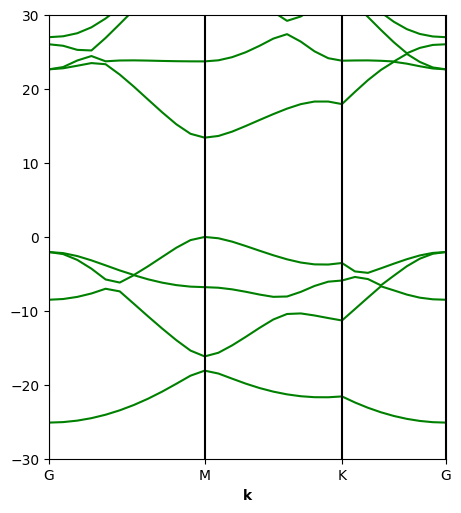

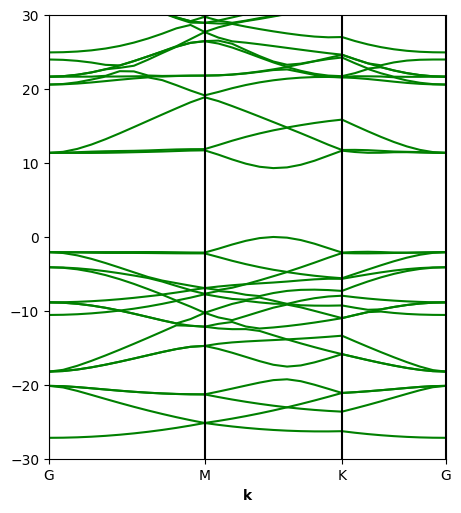

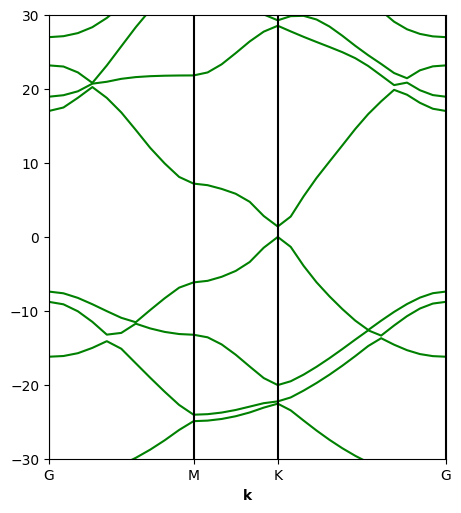

In [41]:
frames = [dataset[name].structures[0] for name in dataset]
pyscf_cells = [dataset[name].cells[0] for name in dataset]
kmesh = [dataset[name].kmesh[0] for name in dataset]
realfocks = [np.asarray(list(dataset[name].matrices_translation.values()))[:,0] for name in dataset]
realovers = [np.asarray(list(dataset[name].overlap_translation.values()))[:,0] for name in dataset]

axes = plot_bands(frames, realfocks, realovers, pyscf_cells, kmesh, 'hexagonal', 'GMKG', 30, y_min=-30, y_max=30)

In [230]:
import spglib

In [253]:
name = list(dataset.keys())[0]
frame = dataset[name].structures[0]
pyscf_cell = dataset[name].cells[0]
kmesh = dataset[name].kmesh[0]

structure = (frame.cell.array, frame.get_scaled_positions(), frame.numbers)
seek_c2 = seekpath.get_explicit_k_path(structure, reference_distance=0.01)
print(seek_c2.keys())
kpts = seek_c2['explicit_kpoints_abs']

dict_keys(['point_coords', 'path', 'has_inversion_symmetry', 'augmented_path', 'bravais_lattice', 'bravais_lattice_extended', 'conv_lattice', 'conv_positions', 'conv_types', 'primitive_lattice', 'primitive_positions', 'primitive_types', 'reciprocal_primitive_lattice', 'inverse_primitive_transformation_matrix', 'primitive_transformation_matrix', 'volume_original_wrt_conv', 'volume_original_wrt_prim', 'spacegroup_number', 'spacegroup_international', 'rotation_matrix', 'explicit_kpoints_rel', 'explicit_kpoints_linearcoord', 'explicit_kpoints_labels', 'explicit_kpoints_abs', 'explicit_segments'])


In [205]:
from ase.dft.kpoints import sc_special_points

In [397]:
from mlelec.utils.pbc_utils import blocks_to_matrix, matrix_to_blocks
from mlelec.utils.twocenter_utils import _to_coupled_basis, _to_uncoupled_basis
matrix_to_blocks?

Signature: matrix_to_blocks(dataset, device=None)
Docstring: <no docstring>
File:      /media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/pbc_utils.py
Type:      function

In [388]:
matrix_to_blocks(dataset['24'])

TensorMap with 1161 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  cell_shift_a  cell_shift_b  cell_shift_c
          0           6       1    0       6       1    0        0             0             0
          0           6       1    0       6       2    0        0             0             0
                                                   ...
          1           6       2    1       6       2    1        7             7             0
          -1          6       2    1       6       2    1        7             7             0

In [ ]:
# HEX22
# name = list(dataset.keys())[1]
# frame = dataset[name].structures[0]
# pyscf_cell = dataset[name].cells[0]
# kmesh = dataset[name].kmesh[0]
# special_points = {'G': [0.0, 0.0, 0.0], 'K': [2*0.3333333333333333, -2*0.3333333333333333, 0.0], 'M': [2*0.5, 0.0, 0.0]}
# kpath = frame.cell.bandpath('GMKG', 100, special_points=special_points, pbc = [True, True, False])
# realfock = np.asarray(list(dataset[name].matrices_translation.values()))[:,0]
# realover = np.asarray(list(dataset[name].overlap_translation.values()))[:,0]
# fig,ax=plot_bands_frame(frame, realfock, realover, pyscf_cell, kmesh=kmesh, kpath = kpath, npoints = 100)
# for l in ax.get_lines():
#     l.set_color('red')
name = list(dataset.keys())[0]
frame = dataset[name].structures[0]
pyscf_cell = dataset[name].cells[0]
kmesh = dataset[name].kmesh[0]
special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, -0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}
kpath = frame.cell.bandpath('GMKG', 100, special_points=special_points, pbc = [True, True, False])
realfock = np.asarray(list(dataset[name].matrices_translation.values()))[:,0]
realover = np.asarray(list(dataset[name].overlap_translation.values()))[:,0]
fig, ax=plot_bands_frame(frame, realfock, realover, pyscf_cell, kmesh=[8,8,1], kpath = kpath, npoints = 100)
    
for l in ax.get_lines():
    l.set_color('blue')


# noise = np.random.normal(scale= 1e-6, size = realfock.shape) 
# noise = 0.5*(noise + np.transpose(noise, axes = (0,2,1)))
# predfock = realfock + noise
plot_bands_frame(frame, predfock, realover, pyscf_cell, kmesh=[8,8,1], kpath = kpath, npoints = 100, ax=ax)
# name = list(dataset.keys())[2]
# frame = dataset[name].structures[0]
# pyscf_cell = dataset[name].cells[0]
# kmesh = dataset[name].kmesh[0]
# special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}
# kpath = frame.cell.bandpath('GMKG', 100, special_points=special_points, pbc = [True, True, False])
# realfock = np.asarray(list(dataset[name].matrices_translation.values()))[:,0]
# realover = np.asarray(list(dataset[name].overlap_translation.values()))[:,0]
# plot_bands_frame(frame, realfock, realover, pyscf_cell, kmesh=[8,8,1], kpath = kpath, npoints = 100, ax = ax)
# # structure = (frame.cell.array, frame.get_scaled_positions(), frame.numbers)
# # seek_c2 = seekpath.get_explicit_k_path(structure, reference_distance=0.01)
# # print(seek_c2.keys())
# # kpts = seek_c2['explicit_kpoints_abs']

In [ ]:
name = list(dataset.keys())[2]
iframe = 8
frame = dataset[name].structures[iframe]
pyscf_cell = dataset[name].cells[iframe]
kmesh = dataset[name].kmesh[iframe]
special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}
kpath = frame.cell.bandpath('GMKG', 100, special_points=special_points, pbc = [True, True, False])
realfock = np.asarray(list(dataset[name].matrices_translation.values()))[:,iframe]
realover = np.asarray(list(dataset[name].overlap_translation.values()))[:,iframe]
fig, ax = plot_bands_frame(frame, realfock, realover, pyscf_cell, kmesh=[8,8,1], kpath = kpath, npoints = 100)
# for l in ax.get_lines():
#     l.set_color('blue')
# iframe = 23
# frame = dataset[name].structures[iframe]
# pyscf_cell = dataset[name].cells[iframe]
# kmesh = dataset[name].kmesh[iframe]
# special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}
# kpath = frame.cell.bandpath('GMKG', 100, special_points=special_points, pbc = [True, True, False])
# realfock2 = np.asarray(list(dataset[name].matrices_translation.values()))[:,iframe]
# realover2 = np.asarray(list(dataset[name].overlap_translation.values()))[:,iframe]
# plot_bands_frame(frame, realfock2, realover2, pyscf_cell, kmesh=[8,8,1], kpath = kpath, npoints = 100, ax=ax, ls='-.', color='red')
# # for l in ax.get_lines():

from metatensor import load 
# predblocks= load('/home/nigam/scratch/MAC/k-hamiltonian/examples/data/periodic/c2/train_cosmosrv/pred_ridges_24-nostupid.npz', use_numpy=True)
predblocks= load('/home/nigam/scratch/MAC/k-hamiltonian/examples/data/periodic/c2/train_cosmosrv/pred_ridges_24.npz', use_numpy=True)


predblocks = predblocks.to(arrays='torch')
from mlelec.utils.twocenter_utils import _to_matrix, _to_uncoupled_basis
from mlelec.utils.pbc_utils import blocks_to_matrix
predblocks_un = _to_uncoupled_basis(predblocks)
recon_blocks = {}
tblocks = []
tblock_keys = []
for translation in dataset['24'].desired_shifts:
    block_keys = []
    blocks = []
    for key, block in predblocks_un.items():
            # TODO: replace labels_where
            try:
                lbl =Labels(
                        ["cell_shift_a", "cell_shift_b", "cell_shift_c"],
                        values=np.asarray(
                            [translation[0], translation[1], translation[2]]
                        ).reshape(1, -1),
                    )
                xx = block.samples.view(["cell_shift_a", "cell_shift_b", "cell_shift_c"]).values
                idx = np.where(np.all(np.isclose(np.array(xx),np.array([translation[0], translation[1], translation[2]])), 
                                      axis = 1))[0]


            except:
                print("{} not found in {}".format(translation, key))
                continue

            if len(idx):
                tblock_keys.append(list(key.values)+[translation[0], translation[1], translation[2]])
    
                tblocks.append( TensorBlock(
                        samples=Labels(
                            predblocks.sample_names[:-3],
                            values=np.asarray(block.samples.values[idx])[:, :-3],
                        ),
                        values=block.values[idx],
                        components=block.components,
                        properties=block.properties,
                    ))
                

tmap = TensorMap(Labels(predblocks_un.keys.names+["cell_shift_a", "cell_shift_b", "cell_shift_c"],np.asarray(tblock_keys)), tblocks)
predfocks = blocks_to_matrix(tmap, dataset['24'])

predfock = np.asarray(list(predfocks.values()))[:,iframe]
plot_bands_frame(frame, predfock, realover, pyscf_cell, kmesh=[8,8,1], kpath = kpath, npoints = 100, ax=ax, ls='-.', color='red')

(<Figure size 512x576 with 1 Axes>, <Axes: xlabel='$\\mathbf{k}$'>)

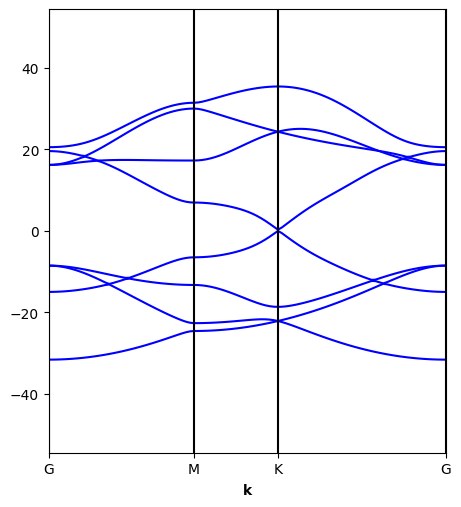

In [434]:
name = list(dataset.keys())[0]
frame = dataset[name].structures[0]
pyscf_cell = dataset[name].cells[0]
kmesh = dataset[name].kmesh[0]
special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, -0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}
kpath = frame.cell.bandpath('GMKG', 100, special_points=special_points, pbc = [True, True, False])
realfock = np.asarray(list(dataset[name].matrices_translation.values()))[:,0]
realover = np.asarray(list(dataset[name].overlap_translation.values()))[:,0]
plot_bands_frame(frame, realfock, realover, pyscf_cell, kmesh=[8,8,1], kpath = kpath, npoints = 100)

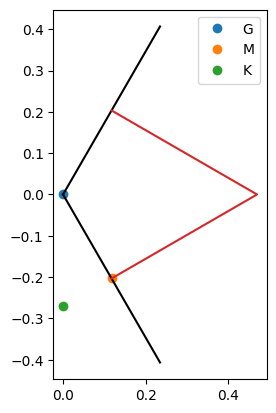

In [278]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

dic = sc_special_points['hexagonal']
# dic = seek_c2['point_coords']
M = dic['M']
K = dic['K']
K = np.array([1/3,-1/3,0])
# K = np.array([0.5,0.5,0])
if 'G' in dic:
    G = dic['G']
elif 'GAMMA' in dic:
    G = dic['GAMMA']

for p, l in zip([G, M, K], ['G', 'M', 'K']):
    x,y,_=frame.cell.reciprocal().array[0]*p[0] + frame.cell.reciprocal().array[1]*p[1]
    ax.plot(x, y, 'o', label = l)

# dic = seek_c2['point_coords']
# M = dic['M']
# K = dic['K']
# if 'G' in dic:
#     G = dic['G']
# elif 'GAMMA' in dic:
#     G = dic['GAMMA']

# for p, l in zip([G, M, K], ['G', 'M', 'K']):
#     x,y=frame.cell.reciprocal().array.dot(p)[:2]
#     plt.plot(x, y, 'o', label = l)

b1 = frame.cell.reciprocal().array[0][:2]
b2 = frame.cell.reciprocal().array[1][:2]
for b in [b1, b2]:
    ax.plot([0, b[0]], [0, b[1]], color = 'black')
ax.plot(0.5*np.array([b1[0], 6/3*(b1[0]+b2[0]), b2[0]]), 0.5*np.array([b1[1], 6/3*(b1[1]+b2[1]), b2[1]]))
ax.legend()
# Draw hexagon

In [257]:
seek_c2['reciprocal_primitive_lattice']

[[2.55464699187918, 1.4749261284459123, 0.0],
 [0.0, 2.9498522568918246, 0.0],
 [0.0, 0.0, 0.08849556770675474]]

In [260]:
frame.cell.reciprocal().array

array([[ 0.23474178, -0.4065847 ,  0.        ],
       [ 0.23474178,  0.4065847 ,  0.        ],
       [ 0.        ,  0.        ,  0.01408451]])

In [258]:
b1,b2

(array([ 0.23474178, -0.4065847 ]), array([0.23474178, 0.4065847 ]))

In [183]:
from mlelec.data.pyscf_calculator import translation_vectors_for_kmesh
from ase.dft.kpoints import sc_special_points as special_points#, get_bandpath
from ase.units import Bohr
points = special_points['hexagonal']
# G = points['G']
# M = points['M']
# K = points['K']
# kmesh = [8,8,1]

R_vec_rel = translation_vectors_for_kmesh(pyscf_cell, kmesh, return_rel=True, wrap_around=True)
R_vec_abs = translation_vectors_for_kmesh(pyscf_cell, kmesh, wrap_around=True)

# mask_x = np.where(R_vec_rel[:,0] == -kmesh[0]//2)[0]
# R_vec_rel[:,0][mask_x] =kmesh[0]//2
# R_vec_abs[:,0][mask_x] = -1*R_vec_abs[:,0][mask_x]

# mask_y = np.where(R_vec_rel[:,1] == -kmesh[1]//2)[0]
# R_vec_rel[:,1][mask_y] = kmesh[1]//2
# R_vec_abs[:,1][mask_y] = -1*R_vec_abs[:,1][mask_y]

# kpath = frame.cell.bandpath(path='GMKG', npoints = 30, pbc= [True, True, False], special_points = special_points['hexagonal'])
# kpts = kpath.kpts # units of icell
kpts = seek_c2['explicit_kpoints_rel']
# kpts_abs = kpath.cartesian_kpts()  #icell = frame.cell.inverse(); np.dot(kpts, icell)
kpts_pyscf = pyscf_cell.get_abs_kpts(kpts)

# kpts_pyscf2 = pyscf_cell.make_kpts(kmesh)

# print(np.linalg.norm(kpts_pyscf[:,:2] - (kpts_abs * Bohr*2*np.pi)[:,:2])) # Should be ~ zero
# kpts_pyscf_scaled = pyscf_cell.get_scaled_kpts(kpts_pyscf)
# print(np.linalg.norm(kpts - kpts_pyscf_scaled), 'scaled') # Should be ~ zero



In [184]:
Hk = np.zeros((len(kpts_pyscf), pyscf_cell.nao, pyscf_cell.nao), dtype=np.complex128)
Sk = np.zeros((len(kpts_pyscf), pyscf_cell.nao, pyscf_cell.nao), dtype=np.complex128)

for i, k in enumerate(kpts_pyscf):
    for r, rrel in zip(R_vec_abs, R_vec_rel):
        phase = 1/np.sqrt(Nk) * np.exp(1j*np.dot(r, k))
        Hk[i] += phase * dataset['hex'].matrices_translation[tuple(rrel%kmesh)][0].numpy()
        Sk[i] += phase * dataset['hex'].overlap_translation[tuple(rrel%kmesh)][0].numpy()
    Hk[i] = 0.5*(Hk[i]+Hk[i].T.conj())
    Sk[i] = 0.5*(Sk[i]+Sk[i].T.conj())    

In [185]:
# xcoords, special_xcoords, labels  = kpath.get_linear_kpoint_axis()
xcoords = seek_c2['explicit_kpoints_linearcoord']
special_xcoords = [seek_c2['explicit_kpoints_linearcoord'][seek_c2['explicit_kpoints_labels'].index(p)] \
                   for p in  np.unique(seek_c2['explicit_kpoints_labels'])[1:]] # list(seek_c2['point_coords'].values()) 
labels = list(seek_c2['point_coords'].keys())
Nk = np.prod(kmesh)
phase = {}
# for kpoint in kpts_pyscf:
#     phase[tuple(kpoint)] = {}
#     for r in R_vec_abs:
#         phase[tuple(kpoint)][tuple(r)] = 1/np.sqrt(Nk) * np.exp(1j*np.dot(r, kpoint))
# Hk = np.zeros((len(kpts_pyscf), pyscf_cell.nao, pyscf_cell.nao), dtype=np.complex128)
# Sk = np.zeros((len(kpts_pyscf), pyscf_cell.nao, pyscf_cell.nao), dtype=np.complex128)

# for i, k in enumerate(kpts_pyscf):
#     for r, rrel in zip(R_vec_abs, R_vec_rel):
#         Hk[i] += phase[tuple(k)][tuple(r)] * dataset['hex'].matrices_translation[tuple(rrel)][0].numpy()
#         Sk[i] += phase[tuple(k)][tuple(r)] * dataset['hex'].overlap_translation[tuple(rrel)][0].numpy()

# phase = np.exp(1j*np.dot(R_vec_abs, kpts_pyscf.T))/np.sqrt(Nk)
# realfock = np.asarray(list(dataset['hex'].matrices_translation.values()))[:,0]
# realover = np.asarray(list(dataset['hex'].overlap_translation.values()))[:,0]
# Hk =  np.einsum('tk, tij ->kij',phase, realfock)
# Sk =  np.einsum('tk, tij ->kij',phase, realover)
        


# print(Hk.shape, Sk.shape)
print(np.linalg.norm(Hk - Hk.conj().transpose(0,2,1), axis = (1,2)).mean())


0.0


In [186]:
import scipy

e_nk = []
for n in range(len(kpts)):
    e_nk.append(scipy.linalg.eigvalsh(Hk[n], Sk[n]))

vbmax = -99
for en in e_nk:
    vb_k = en[pyscf_cell.nelectron//2-1]
    if vb_k > vbmax:
        vbmax = vb_k
e_nk = [en - vbmax for en in e_nk]

from ase.units import Hartree
emin = -2* Hartree
emax = 2*Hartree

GAMMA X
Y GAMMA
GAMMA Z
R_2 GAMMA
GAMMA T_2
U_2 GAMMA
GAMMA V_2


IndexError: index 939 is out of bounds for axis 0 with size 939

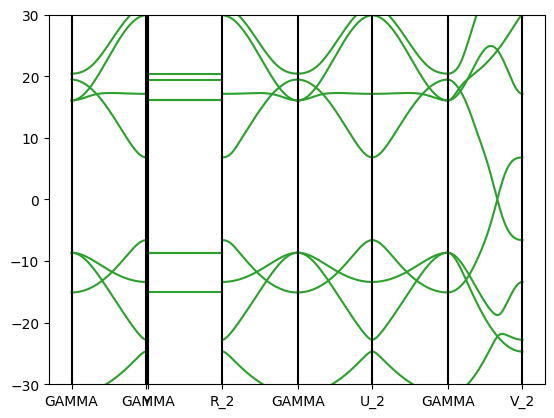

In [190]:
fig, ax = plt.subplots()

labels_dict = {'GAMMA': r'$\Gamma$', 'M': 'M', 'K': 'K'}

hs_pts = []
hs_lbl = []

emin = -30 #-2*Hartree
emax = 30 #2*Hartree


for (i, f), (l1, l2) in zip(seek_c2['explicit_segments'], seek_c2['path']):
    print(l1,l2)
    x = seek_c2['explicit_kpoints_linearcoord'][i:f]
    y = np.array([e_nk[v]*Hartree for v in range(i, f)])
    ax.plot(x, y, color = 'tab:green')
    p = seek_c2['explicit_kpoints_linearcoord'][i]
    ax.plot([p, p], [emin, emax], color = 'k')
    hs_pts.append(p)
    hs_lbl.append(l1)
    # hs_lbl.append(labels_dict[l1])
p = seek_c2['explicit_kpoints_linearcoord'][f-1]
hs_pts.append(p)
hs_lbl.append(l2)
# hs_lbl.append(labels_dict[l2])
ax.plot([p, p], [emin, emax], color = 'k')
ax.set_xticks(hs_pts)
ax.set_xticklabels(hs_lbl)
ax.set_ylim(emin, emax)
ax.set_xlim(seek_c2['explicit_kpoints_linearcoord'][0], seek_c2['explicit_kpoints_linearcoord'][f])

# for p in special_xcoords:
#     plt.plot([p, p], [emin, emax], 'k-')

In [77]:
sc_matrices = [np.asarray([dataset['hex'].matrices_translation[T][ifr] for T in dataset['hex'].matrices_translation]).reshape(80,80) for ifr in range(len(frames))]

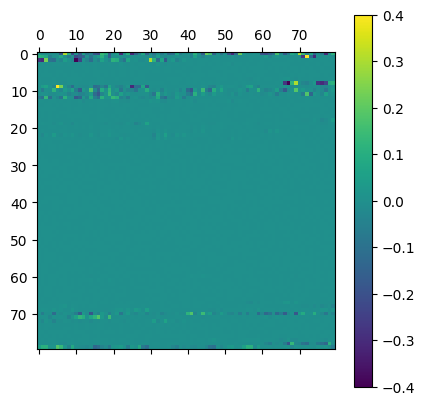

In [118]:
plt.matshow(sc_matrices[7]-sc_matrices[8])
plt.colorbar()

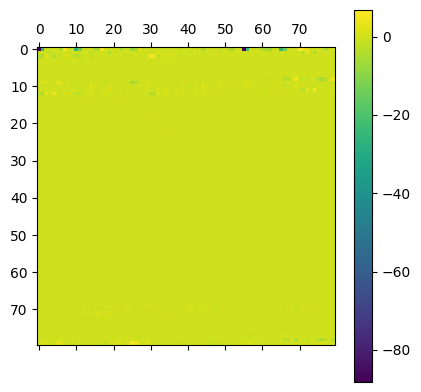

In [115]:
plt.matshow(sc_matrices[4])
plt.colorbar()

## C2 24 

In [6]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 
# from mlelec.utils.twocenter_utils import _to_blocks  

def get_targets(dataset, device ="cpu"):
    blocks = matrix_to_blocks(dataset)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry=True, device= device, translations=True)
    

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks


In [7]:
target_blocks = {name: get_targets(dataset[name])[0] for name in ['24']}
target_coupled_blocks = {name: get_targets(dataset[name])[1] for name in ['24']}

In [8]:
target_coupled_blocks

{'24': TensorMap with 33 blocks
 keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
           0           6       1    0       6       1    0   0
           0           6       1    0       6       2    0   0
                                ...
           -1          6       2    1       6       2    1   1
           -1          6       2    1       6       2    1   2}

In [9]:
pred_ = load('examples/data/periodic/c2/train_cosmosrv/pred_ridges_24-nostupid.npz', use_numpy=True)
loss_blocks = {}
for k, b in target_coupled_blocks['24'].items():
    loss_blocks[tuple(k)] = torch.linalg.norm(b.values - pred_.block(k).values)**2

loss_= sum(loss_blocks.values())
print(loss_)

tensor(1.6201)


In [35]:
import metatensor.operations as ops 
loss_frame = {}
block_norms = {}
for ifr in range(len(frames)): 
    if ifr==3: 
        continue
    loss_frame[ifr] = {}
    block_norms[ifr] = {}
    frame_target = ops.slice(target_coupled_blocks['24'], axis= 'samples', labels=Labels(['structure'], np.array([[ifr]])))
    frame_pred = ops.slice(pred_, axis= 'samples', labels=Labels(['structure'], np.array([[ifr]])))
    
    for (k, b),(k1,b1) in zip(frame_target.items(), frame_pred.items()):
        loss_frame[ifr][tuple(k)] = torch.linalg.norm(b.values - b1.values)**2
        block_norms[ifr][tuple(k)] = torch.linalg.norm(b.values) 

In [36]:
np.sum( [list(loss_frame[ifr].values()) for ifr in loss_frame])

0.10795432446778783

In [123]:
hfeat_norms = np.load('examples/data/periodic/c2/train_cosmosrv/hfeat_norms.npy', allow_pickle=True).item()


In [ ]:
feat_frame = {}
for ifr in fock_range: 
    feat_frame[ifr] = {}

    frame_target = ops.slice(hfeat, axis= 'samples', labels=Labels(['structure'], np.array([[ifr]])))
    
    for (k, b) in frame_target.items():
        feat_frame[ifr][tuple(k)] = np.linalg.norm(b.values) 

In [187]:
val,idx,counts=np.unique([block_norms[ifr][tuple(k)] for ifr in range(24)], return_counts=True, return_index=True)
np.sort(counts)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [21]:
view(frames)

<Popen: returncode: None args: ['/home/nigam/miniconda3/bin/python', '-m', '...>

IndexError: index 23 is out of bounds for axis 0 with size 23

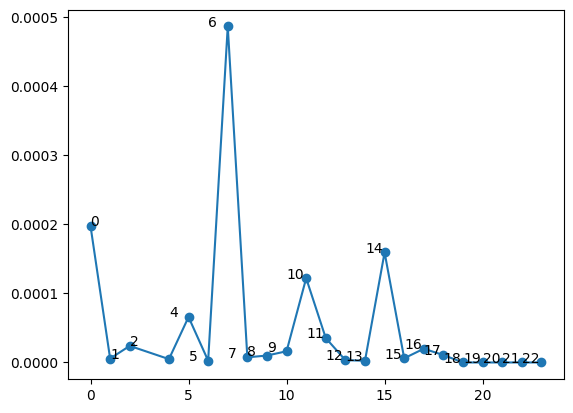

In [37]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
ks = [
    # [1,  6,  1,  0,  6,  2,  1,  1],
      [-1,  6,  1,  0,  6,  2,  1,  1],
      # [ 1,  6,  2,  1,  6,  2,  1,  0],
      # [ -1,  6,  2,  1,  6,  2,  1,  0],
      # [ 1,  6,  2,  1,  6,  2,  1,  1],
      # [ -1,  6,  2,  1,  6,  2,  1,  0],
      [ 1,  6,  2,  1,  6,  2,  1,  2],
      # [ -1,  6,  2,  1,  6,  2,  1,  2]
     ]
featkey = [ 
            [3, 1, 1, 6, 6, -1],
    [3, 1, 2, 6, 6, 1]
]
# color_cycle = plt.cm._get_lines.color_cycle
axes = []
handles=[]
labels=[]
for k,fk in zip(ks,featkey):
    fig, ax = plt.subplots()
    # axes.append(ax.twinx())
    losses = np.array([loss_frame[ifr][tuple(k)].numpy() for ifr in loss_frame])
    x = [ifr for ifr in loss_frame]
    
# ax.hist(losses)
    pl,=ax.plot([0],[0],lw=0)
    # pl,=axes[-1].plot(range(24), losses, '-o', label = k, color=pl.get_color())
    pl,=ax.plot(x, losses, '-o', label = k, color=pl.get_color())

    ym,yM=ax.get_ylim()
    delta=yM-ym
    for ifr in block_norms:
        # ax.annotate(f'{ifr}--{block_norms[ifr][tuple(k)].item():.2e}', xy=(ifr, losses[ifr]))
        ax.annotate(f'{ifr}', xy=(ifr, losses[ifr]))
        # ax.annotate(f'{ifr}-{block_norms[ifr][tuple(k)].item():.2e}', xy=(ifr, losses[ifr]))
        # ax.annotate(f'{hfeat_norms[ifr][tuple(fk)]:.2e}', xy=(ifr, losses[ifr]-delta*0.05))
    ax.legend()
    ax.set_xlim(0,24)
#     handles.append(pl)
#     labels.append(k)
# ax.legend(handles,labels,loc='center left', bbox_to_anchor=(1.2,0.5))

In [125]:
hfeat_norms

{0: {(3, 1, 0, 6, 6, 0): 9.097396,
  (3, 1, 1, 6, 6, 0): 0.6262477,
  (3, 1, 2, 6, 6, 0): 13.937294,
  (3, 1, 3, 6, 6, 0): 12.641046,
  (3, -1, 1, 6, 6, 0): 0.018247489,
  (3, -1, 2, 6, 6, 0): 0.4864036,
  (3, -1, 3, 6, 6, 0): 0.67403245,
  (3, -1, 0, 6, 6, 0): 0.00017152075,
  (3, 1, 0, 6, 6, 1): 13.171967,
  (3, 1, 0, 6, 6, -1): 3.9273574,
  (3, 1, 1, 6, 6, 1): 9.180235,
  (3, 1, 1, 6, 6, -1): 21.611542,
  (3, 1, 2, 6, 6, 1): 30.744743,
  (3, 1, 2, 6, 6, -1): 11.924061,
  (3, 1, 3, 6, 6, 1): 14.20525,
  (3, 1, 3, 6, 6, -1): 32.158245,
  (3, -1, 1, 6, 6, 1): 4.297552,
  (3, -1, 1, 6, 6, -1): 7.32977,
  (3, -1, 2, 6, 6, 1): 9.432269,
  (3, -1, 2, 6, 6, -1): 18.025658,
  (3, -1, 3, 6, 6, 1): 18.280693,
  (3, -1, 3, 6, 6, -1): 10.509862,
  (3, -1, 0, 6, 6, 1): 0.0054351743,
  (3, -1, 0, 6, 6, -1): 0.0604024},
 1: {(3, 1, 0, 6, 6, 0): 8.571795,
  (3, 1, 1, 6, 6, 0): 0.99372596,
  (3, 1, 2, 6, 6, 0): 13.097979,
  (3, 1, 3, 6, 6, 0): 12.020926,
  (3, -1, 1, 6, 6, 0): 0.0104065165,
  (3, -1,

In [42]:
for k, b in target_coupled_blocks['hex'].items():
    print(f'[{" ".join([f"{s:>2d}," for s in k.values])}]  {torch.linalg.norm(b.values).item():.2e}, {loss_blocks[tuple(k)].item():.2e}')

[ 0,  6,  1,  0,  6,  1,  0,  0,]  6.11e+02, 4.75e-07
[ 0,  6,  1,  0,  6,  2,  0,  0,]  1.65e+02, 2.24e-08
[ 0,  6,  1,  0,  6,  2,  1,  1,]  5.57e-02, 1.09e-13
[ 0,  6,  2,  0,  6,  1,  0,  0,]  1.65e+02, 2.24e-08
[ 0,  6,  2,  0,  6,  2,  0,  0,]  9.63e+01, 6.04e-07
[ 0,  6,  2,  0,  6,  2,  1,  1,]  1.57e+00, 1.65e-13
[ 0,  6,  2,  1,  6,  1,  0,  1,]  5.57e-02, 1.09e-13
[ 0,  6,  2,  1,  6,  2,  0,  1,]  1.57e+00, 1.65e-13
[ 0,  6,  2,  1,  6,  2,  1,  0,]  4.45e+01, 1.40e-06
[ 0,  6,  2,  1,  6,  2,  1,  1,]  4.40e-16, 1.65e-16
[ 0,  6,  2,  1,  6,  2,  1,  2,]  2.02e+01, 5.65e-09
[ 1,  6,  1,  0,  6,  1,  0,  0,]  3.00e-02, 1.78e-07
[-1,  6,  1,  0,  6,  1,  0,  0,]  1.04e-12, 1.09e-24
[ 1,  6,  1,  0,  6,  2,  0,  0,]  5.26e+01, 9.73e-09
[-1,  6,  1,  0,  6,  2,  0,  0,]  2.07e-03, 3.68e-10
[ 1,  6,  1,  0,  6,  2,  1,  1,]  7.78e-03, 5.62e-10
[-1,  6,  1,  0,  6,  2,  1,  1,]  8.74e+01, 1.11e-01
[ 1,  6,  2,  0,  6,  1,  0,  0,]  5.26e+01, 9.72e-09
[-1,  6,  2,  0,  6,  1,  0,

In [56]:
keys = [[-1,  6,  1,  0,  6,  2,  1,  1], [ 1,  6,  2,  1,  6,  2,  1,  2]]
sample_idx = 100
for k in keys:
    b = target_coupled_blocks['hex'].block(bkey)
    bkey = Labels(target_coupled_blocks['hex'].keys.names, np.asarray(k).reshape(1,-1))
    print(target_coupled_blocks['hex'].block(bkey).values[sample_idx])
    print()
    print(pred_.block(bkey).values[sample_idx])
    print()

tensor([[ 1.9081e-07],
        [-1.2094e-06],
        [ 1.1727e-06]])

[[-1.2288465e-06]
 [ 1.2046726e-05]
 [-2.5015042e-05]]

tensor([[ 1.1322e-04],
        [ 1.9674e-05],
        [ 1.7823e-03],
        [-5.9196e-06],
        [ 9.8322e-05]])

[[4.0667036e-04]
 [5.7109901e-05]
 [1.4171307e-03]
 [4.1607036e-05]
 [7.8619385e-05]]



In [60]:
b.samples.values.shape

(4560, 6)

In [73]:
# 4560/24 - 63*3 -1 

0.0

In [72]:
b.samples

LabelsValues([[ 0,  0,  0,  0,  1,  0],
              [ 0,  0,  0,  0,  2,  0],
              [ 0,  0,  0,  0,  3,  0],
              ...,
              [23,  1,  1,  7,  5,  0],
              [23,  1,  1,  7,  6,  0],
              [23,  1,  1,  7,  7,  0]], dtype=int32)

In [6]:
# kfock['hex'].shape, kfock['double_hex'].shape

# submatrices 

In [7]:
# ssmatrices= np.zeros((36,4,4), dtype = np.complex128)
# for i,matrix in enumerate(kfock['hex']):
#     ssmatrices[i, 0, 0]= matrix[0,0] 
#     ssmatrices[i, 0, 1]= matrix[0,1] 
    
#     ssmatrices[i, 0, 2]= matrix[0,5] 
#     ssmatrices[i, 0, 3]= matrix[0,6] 
    
#     ssmatrices[i, 1, 0]= matrix[1,0] 
#     ssmatrices[i, 1, 1]= matrix[1,1] 
    
#     ssmatrices[i, 1, 2]= matrix[1,5] 
#     ssmatrices[i, 1, 3]= matrix[1,6]     
    
#     ssmatrices[i, 2, 0]= matrix[5,0] 
#     ssmatrices[i, 2, 1]= matrix[5,1] 
    
#     ssmatrices[i, 2, 2]= matrix[5,5] 
#     ssmatrices[i, 2, 3]= matrix[5,6] 
    
#     ssmatrices[i, 3, 0]= matrix[6,0] 
#     ssmatrices[i, 3, 1]= matrix[6,1] 
    
#     ssmatrices[i, 3, 2]= matrix[6,5] 
#     ssmatrices[i, 3, 3]= matrix[6,6] 
#_-------p-p submatrix only ----
# ssmatrices= np.zeros((36,6,6), dtype = np.complex128)
# for i,matrix in enumerate(kfock['hex']):
#     ssmatrices[i, 0:3, 0:3]= matrix[2:5, 2:5]
#     ssmatrices[i, 0:3, 3:]= matrix[2:5, 7:10]
    
#     ssmatrices[i, 3:, 0:3]= matrix[7:10, 2:5] 
#     ssmatrices[i, 3:, 3:]= matrix[7:10, 7:10] 
    
# ssorbs = {6: [[2,1,1],[2,1,-1],[2,1,0]]}
#-------

# ssorbs = {6:[[1, 0, 0], [2,0,0]]}
# dataset = {name: PySCFPeriodicDataset(frames = [frames[i]], kgrid=kmesh[i], matrices_kpoint = ssmatrices.reshape(1, *ssmatrices.shape), target=["real_translation"] ,device = "cpu", orbs = ssorbs, nao=ssmatrices.shape[-1]) for i,name in enumerate(['hex'])}

# from mlelec.utils.twocenter_utils import fix_orbital_order
# for name in dataset: 
#     for T in dataset[name].matrices_translation: 
#         dataset[name].matrices_translation[T] = fix_orbital_order(dataset[name].matrices_translation[T], dataset[name].structures, dataset[name].basis)
# #         dataset[name].matrices_kpoints = fix_orbital_order(dataset[name].matrices_kpoint[T], dataset[name].structures, dataset[name].basis)
        

# MATRICEs 

In [8]:
# from mlelec.utils.pbc_utils import matrix_to_blocks, blocks_to_matrix

                                             
# blocks = matrix_to_blocks(dataset['hex'])
# rmatrices = blocks_to_matrix(blocks, dataset['hex'])
# for T in dataset['hex'].matrices_translation:
#     norm = torch.linalg.norm(dataset['hex'].matrices_translation[T][0] - rmatrices[T][0])
#     if norm>1e-6:
#         print(T,norm)

In [7]:
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 
# from mlelec.utils.twocenter_utils import _to_blocks  

def get_targets(dataset, device ="cpu"):
    blocks = matrix_to_blocks(dataset)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry=True, device= device, translations=True)
    

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks



In [8]:
from metatensor import load

In [9]:
# load('hfeat_hex.npz', use_numpy=True)

In [10]:
target_blocks = {name: get_targets(dataset[name])[0] for name in dataset}
target_coupled_blocks = {name: get_targets(dataset[name])[1] for name in dataset}

# target_blocks = {name: get_targets(dataset[name], shift=[[0,0,0]], return_uncoupled=True)[0] for name in dataset}
# target_blocks = {name: get_targets(dataset[name])[0] for name in dataset}
# target_coupled_blocks = {name: get_targets(dataset[name], shift=[[0,0,0]])[1] for name in dataset}


In [13]:
# from mlelec.utils.twocenter_utils import _orbs_offsets, _atom_blocks_idx, _to_coupled_basis, _to_uncoupled_basis
# device = "cpu"
# coupled_blocks = _to_coupled_basis(blocks, skip_symmetry=True, device= device, translations=True)
# uncoupled_blocks = _to_uncoupled_basis(coupled_blocks, device= device, translations=True)
# for k, b in uncoupled_blocks.items():
#     norm = torch.linalg.norm(b.values-blocks.block(k).values)
#     if norm > 1e-6:
#         print(norm, k)
# rmatrices = blocks_to_matrix(blocks, dataset = dataset['hex'])
# for T in dataset['hex'].matrices_translation:
#     norm = torch.linalg.norm(dataset['hex'].matrices_translation[T][0] - rmatrices[T][0])
#     if norm>1e-6:
#         print(T,norm)

## FEATURES 

In [11]:
hypers_pair = {'cutoff': 4,
          'max_radial':10, 
          'max_angular':4,
          'atomic_gaussian_width':0.6,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}

hypers_atom = {'cutoff': 4,
          'max_radial':10, 
          'max_angular':4,
          'atomic_gaussian_width':0.3,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}
device = "cpu"

In [12]:
new_names=['ortho', 'hex', 'hex22', 'hex33', 'hex23']
NAMES_START=1
NAMES_STOP=2
LCUT = 3 #2*np.max([np.max( np.asarray(orbitals[ORBS][k])[:,1]) for k in orbitals[ORBS]])
print("LCUT", LCUT)
both_centers = True
rhoij = {newname:pair_features(dataset[name].structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, 
                               both_centers=both_centers, max_shift = dataset[name].kmesh[0] ,  
                               desired_shifts = dataset[name].desired_shifts_sup, mic=True, kmesh = dataset[name].kmesh[0], 
                               device="cpu", lcut = LCUT) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}
# gij = {newname:pair_features(dataset[name].structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, both_centers=both_centers, max_shift = dataset[name].kmesh[0] ,  desired_shifts = dataset[name].desired_shifts_sup, mic=True, kmesh = dataset[name].kmesh[0], device="cpu", return_rho0ij=True) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}
# #THIS IS SLOW 

LCUT 3
hypers_pair {'cutoff': 11.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:147: UserWarning: Using cutoff 11.0 for all pairs feature
  warnings.warn(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:167: UserWarning: Using kmesh [8, 8, 1] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


0 0 0 mic 0 -1 0 m_mic 0 1 0
0 0 0 mic 0 -2 0 m_mic 0 2 0
0 0 0 mic 0 -3 0 m_mic 0 3 0
0 0 0 mic 0 -4 0 m_mic 0 4 0
0 0 0 mic 0 3 0 m_mic 0 -3 0
0 0 0 mic 0 2 0 m_mic 0 -2 0
0 0 0 mic 0 1 0 m_mic 0 -1 0
0 0 0 mic 1 0 0 m_mic 1 0 0
0 0 0 mic 1 1 0 m_mic 1 1 0
0 0 0 mic 1 2 0 m_mic 1 2 0
0 0 0 mic 1 3 0 m_mic 1 3 0
0 0 0 mic 1 4 0 m_mic 1 4 0
0 0 0 mic 1 -3 0 m_mic 1 -3 0
0 0 0 mic 1 -2 0 m_mic 1 -2 0
0 0 0 mic 1 -1 0 m_mic 1 -1 0
0 0 0 mic 2 0 0 m_mic 2 0 0
0 0 0 mic 2 1 0 m_mic 2 1 0
0 0 0 mic 2 2 0 m_mic 2 2 0
0 0 0 mic 2 3 0 m_mic 2 3 0
0 0 0 mic 2 4 0 m_mic 2 4 0
0 0 0 mic 2 -3 0 m_mic 2 -3 0
0 0 0 mic 2 -2 0 m_mic 2 -2 0
0 0 0 mic 2 -1 0 m_mic 2 -1 0
0 0 0 mic 3 0 0 m_mic 3 0 0
0 0 0 mic 3 1 0 m_mic 3 1 0
0 0 0 mic 3 2 0 m_mic 3 2 0
0 0 0 mic 3 3 0 m_mic 3 3 0
0 0 0 mic 3 4 0 m_mic 3 4 0
0 0 0 mic 5 3 0 m_mic 5 3 0
0 0 0 mic 5 2 0 m_mic 5 2 0
0 0 0 mic 3 -1 0 m_mic 3 -1 0
0 0 0 mic 4 0 0 m_mic 4 0 0
0 0 0 mic 4 1 0 m_mic 4 1 0
0 0 0 mic 4 2 0 m_mic 4 2 0
0 0 0 mic 4 3 0 m_mic 4 3 0

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:382: UserWarning: nu_j not defined, using nu_i for nu_j as well
  warnings.warn("nu_j not defined, using nu_i for nu_j as well")


In [119]:
# both_centers=False
mic=True
# # desired_shifts = None
# # desired_shifts = dataset[name].desired_shifts_sup
gij = {newname:pair_features(dataset[name].structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, both_centers=both_centers, max_shift = [8,8,1] ,  desired_shifts =  dataset[name].desired_shifts_sup, mic=mic, kmesh = dataset[name].kmesh[0], device="cpu", return_rho0ij=True) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:147: UserWarning: Using cutoff 11.0 for all pairs feature
  warnings.warn(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:167: UserWarning: Using kmesh [8, 8, 1] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


hypers_pair {'cutoff': 11.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}
0 0 0 mic 0 -1 0 m_mic 0 1 0
0 0 0 mic 0 -2 0 m_mic 0 2 0
0 0 0 mic 0 -3 0 m_mic 0 3 0
0 0 0 mic 0 -4 0 m_mic 0 4 0
0 0 0 mic 0 3 0 m_mic 0 -3 0
0 0 0 mic 0 2 0 m_mic 0 -2 0
0 0 0 mic 0 1 0 m_mic 0 -1 0
0 0 0 mic 1 0 0 m_mic 1 0 0
0 0 0 mic 1 1 0 m_mic 1 1 0
0 0 0 mic 1 2 0 m_mic 1 2 0
0 0 0 mic 1 3 0 m_mic 1 3 0
0 0 0 mic 1 4 0 m_mic 1 4 0
0 0 0 mic 1 -3 0 m_mic 1 -3 0
0 0 0 mic 1 -2 0 m_mic 1 -2 0
0 0 0 mic 1 -1 0 m_mic 1 -1 0
0 0 0 mic 2 0 0 m_mic 2 0 0
0 0 0 mic 2 1 0 m_mic 2 1 0
0 0 0 mic 2 2 0 m_mic 2 2 0
0 0 0 mic 2 3 0 m_mic 2 3 0
0 0 0 mic 2 4 0 m_mic 2 4 0
0 0 0 mic 2 -3 0 m_mic 2 -3 0
0 0 0 mic 2 -2 0 m_mic 2 -2 0
0 0 0 mic 2 -1 0 m_mic 2 -1 0
0 0 0 mic 3 0 0 m_mic 3 0 0
0 0 0 mic 3 1 0 m_mic 3 1 0
0 0 0 mic 3 2 0 m_mic 3 2 0
0 0 0 mic 3 3 0 m_mic 3 3 0
0 0 0 mic 3 4 0 m_mic 

In [55]:
gij_nofix = gij['hex'].copy()
# gij_nofix = gij['hex'].copy()


In [120]:
gij_fix = gij['hex'].copy()


In [71]:
gij_nofix_sort = metatensor.sort(gij_nofix, axes='samples')

In [121]:
gij_fix_sort = metatensor.sort(gij_fix, axes='samples')

In [78]:
np.linalg.norm(gij_fix_sort[0].samples.values[:,:6]-gij_nofix_sort[0].samples.values[:,:6])

0.0

In [122]:
for k, b in gij_fix_sort.items():
    # if k['spherical_harmonics_l']==0:
    # print(torch.linalg.norm(gij_nofix_sort.block(k).values-b.values))
        print(torch.linalg.norm(gij_nofix_sort.block(k).values-b.values))
        idx = torch.where(gij_nofix_sort.block(k).values!=b.values)[0]
        
        print(b.samples.values[idx])
        
        print(gij_nofix_sort.block(k).samples.values[idx])

tensor(0., dtype=torch.float64)
[]
[]
tensor([[ 0.0072, -0.0201,  0.0973,  0.1356,  0.0056,  0.0176, -0.0089,  0.0040,
         -0.0013,  0.0002]], dtype=torch.float64) tensor([], size=(0, 1, 10), dtype=torch.float64)
tensor(0., dtype=torch.float64)
[]
[]
tensor([[ 1.1479e-02, -3.2307e-02,  1.5470e-01,  2.1730e-01,  9.0091e-03,
          2.8259e-02, -1.4235e-02,  6.4205e-03, -2.0776e-03,  3.3953e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.7067e-03, -1.0433e-02,  4.9957e-02,  7.0170e-02,  2.9093e-03,
          9.1256e-03, -4.5968e-03,  2.0734e-03, -6.7091e-04,  1.0964e-04]],
       dtype=torch.float64) tensor([], size=(0, 3, 10), dtype=torch.float64)
tensor(0., dtype=torch.float64)
[]
[]
tensor([[ 0.0074, -0.0211,  0.0990,  0.1412,  0.0060,  0.0183, -0.0092,  0.0041,
         -0.0013,  0.0002],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 

In [97]:
print(b.samples[126], gij_nofix_sort.block(k).samples[126])
print(b.values[126], gij_nofix_sort.block(k).values[126])

LabelsEntry(structure=0, center=0, neighbor=1, cell_shift_a=-7, cell_shift_b=-7, cell_shift_c=0, cell_shift_a_MIC=1, cell_shift_b_MIC=1, cell_shift_c_MIC=0) LabelsEntry(structure=0, center=0, neighbor=1, cell_shift_a=-7, cell_shift_b=-7, cell_shift_c=0, cell_shift_a_MIC=1, cell_shift_b_MIC=1, cell_shift_c_MIC=0)
tensor([[-1.0743e-02,  3.2386e-02, -1.4339e-01, -2.1574e-01, -9.8959e-03,
         -2.7863e-02,  1.3731e-02, -6.1367e-03,  1.9810e-03, -3.2311e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-5.0060e-03,  1.5091e-02, -6.6814e-02, -1.0053e-01, -4.6112e-03,
         -1.2983e-02,  6.3984e-03, -2.8595e-03,  9.2309e-04, -1.5056e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.7417e-03, -1.7309e-02,  7.6634e-02,  1.1530e-01,  5.2889e-03,
          1.4891

In [13]:
if both_centers: 
    NU = 3
else: 
    NU = 2
rhonui = {newname: single_center_features(dataset[name].structures, hypers_atom, order_nu=NU, lcut=LCUT, 
                                          device = device, feature_names = rhoij[newname].property_names,) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}


In [14]:
hfeat_tc= {name: twocenter_features_periodic_NH(single_center=rhonui[name], pair= rhoij[name]) for name in new_names[NAMES_START:NAMES_STOP]}

570
570
570
570
570
570
570
570


In [56]:
# hfeat_tc['hex'].save('examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex', use_numpy=True)
# hfeat_tc['hex22'].save('examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex22', use_numpy=True)

# hfeat_tc['hex'].save('examples/data/periodic/c2/hfeat_tc_hex/results_C2_rotated_881/hfeat_tc.npz', use_numpy=True) # ROTATED structure
# aa = load("rhoij_hex.npz", use_numpy=True) 
# aa.to(arrays='torch')

/home/nigam/miniconda3/lib/python3.11/site-packages/metatensor/io.py:408: UserWarning: adding '.npz' extension, the file will be saved at 'examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex.npz'
  warnings.warn(
/home/nigam/miniconda3/lib/python3.11/site-packages/metatensor/io.py:408: UserWarning: adding '.npz' extension, the file will be saved at 'examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex22.npz'
  warnings.warn(


# original features for the UC 

In [75]:
xframe = []
for f in frames[1:2]:
    fr = f.copy()
    fr.pbc=False
    fr.cell = [100,100,100]
    xframe.append(fr)

In [76]:

xpair = pair_features(xframe, hypers_atom, hypers_pair, order_nu=1, all_pairs=False, both_centers=True, device="cpu")
xfeat = twocenter_hermitian_features(single_center = None, pair = xpair)

/home/nigam/miniconda3/lib/python3.11/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


In [77]:
for k, b in xpair.items():
    for isample in range(len(b.samples.values)):
        ifr, i, j = b.samples.values[isample]
        if i==j:
            continue
    
        rij= rhoij['hex'].block(k)
        lbl = Labels(rij.samples.names, values = np.array([[ifr, i, j, 0,0,0,0,0,0]]))
        _,sidx = labels_where(rij.samples, lbl, return_idx=True )
        print(ifr, i, j , sidx)
        print(b.values[isample] - rij.values[sidx])

0 0 1 [189]
tensor([[[-2.3974e-01, -2.0339e-01,  1.7879e-01,  ..., -5.1290e-06,
          -9.7354e-07, -3.2167e-07]]])


ValueError: selected key ['structure', 'center', 'neighbor', 'cell_shift_a', 'cell_shift_b', 'cell_shift_c', 'cell_shift_a_MIC', 'cell_shift_b_MIC', 'cell_shift_c_MIC'] = [0 0 2 0 0 0 0 0 0] not found in the output keys. Check the `selection` argument.

In [54]:
for k, b in xfeat.items():
    for isample in range(len(b.samples.values)):
        ifr, i, j = b.samples.values[isample]
        if i==j:
            continue
    
        rij= hfeat_tc['hex'].block(k)
        lbl = Labels(rij.samples.names, values = np.array([[ifr, i, j, 0,0,0,0,0,0]]))
        _,sidx = labels_where(rij.samples, lbl, return_idx=True )
        print(ifr, i, j , sidx)
        print(b.values[isample] - rij.values[sidx])

MetatensorError: invalid parameter: 'cell_shift_a' is not part of the keys for this tensor

In [15]:
# hfeat_ji = hfeat_tc['hex'].copy()
# hfeat_up = hfeat_tc['hex'].copy()

In [16]:
# from torch.linalg import norm
# for k, b in hfeat_ji.items():
#     sigma = k['inversion_sigma']
# #     nr = norm(b.values) - norm(hfeat_up.block(k).values)
    
#     nr = norm(b.values - hfeat_up.block(k).values)
#     if nr>1e-7:
#         print(k, nr, b.values , hfeat_up.block(k).values)
#         break

In [17]:
# b.values[torch.where((b.values - hfeat_up.block(k).values)>1e-4)]

In [18]:
# from sklearn.decomposition import PCA
# from mlelec.features.acdc_utils import _pca
# hfeat_hexpca = _pca(hfeat['hex'])


# ROTATION TEST 

In [37]:
# hfeat_tc={}
# hfeat_tc['hex'] = load("examples/data/periodic/c2/results_C2_rotated_881/hfeat_tc.npz", use_numpy=True) 
# hfeat_tc['hex'] = hfeat_tc['hex'].to(arrays='torch')

In [15]:
from mlelec.utils.symmetry import _wigner_d_real, rotate_frame, _rotation_matrix_from_angles
import hickle

In [16]:
rotation = hickle.load('/home/nigam/scratch/MAC/mlelec/examples/data/water_rotated/rotations.hickle')

In [17]:
# x=rotate_frame(frames[0], _rotation_matrix_from_angles(*rotation[1]))
# frames[2].positions - x.positions

In [18]:
feat = hfeat_tc
for k, b in feat['hex'].items():
   
        lbl1 = Labels(b.samples.names[:1], values = np.array([[0]]))
        sample1,sidx1 = labels_where(b.samples, lbl1, return_idx=True )
    
        lbl2 = Labels(b.samples.names[:1], values = np.array([[1]]))
        sample2,sidx2 = labels_where(b.samples, lbl2, return_idx=True )
        v1 = b.values[sidx1]
        v2 = b.values[sidx2] 
        L = k["spherical_harmonics_l"]
        wd = _wigner_d_real(L, *rotation[0]).to(b.values)
        v1_rot = torch.einsum('mn, snp->smp', wd, v1)
        assert np.all(sample1.values[:,1:] ==sample2.values[:,1:])
        if torch.linalg.norm(v1_rot - v2) > 1e-6:
            
            print(k.values, torch.linalg.norm(v1_rot - v2), np.linalg.norm(v1_rot), np.linalg.norm(v2))
        # if k['spherical_harmonics_l']==1:
        #      break


[3 1 2 6 6 0] tensor(1.2170e-06) 17.09286 17.092861
[3 1 3 6 6 0] tensor(1.1005e-06) 14.451293 14.451231
[ 3  1  0  6  6 -1] tensor(0.0639) 4.198944 4.198944
[ 3  1  1  6  6 -1] tensor(1.7349) 24.39134 24.391092
[3 1 2 6 6 1] tensor(2.7382e-06) 34.757538 34.756935
[ 3  1  2  6  6 -1] tensor(1.0585) 12.806403 12.806394
[3 1 3 6 6 1] tensor(1.3880e-06) 15.279838 15.278668
[ 3  1  3  6  6 -1] tensor(2.8915) 36.18892 36.188015
[ 3 -1  1  6  6 -1] tensor(1.0798) 7.8203564 7.8202767
[ 3 -1  2  6  6  1] tensor(1.0141e-06) 10.113193 10.113056
[ 3 -1  2  6  6 -1] tensor(1.4754) 20.653122 20.652864
[ 3 -1  3  6  6  1] tensor(1.8454e-06) 20.817873 20.817661
[ 3 -1  3  6  6 -1] tensor(1.2645) 11.300896 11.300827


In [298]:
for k, b in target_coupled_blocks['hex'].items():
    lbl1 = Labels(b.samples.names[:1], values = np.array([[0]]))
    _,sidx1 = labels_where(b.samples, lbl1, return_idx=True )

    lbl2 = Labels(b.samples.names[:1], values = np.array([[1]]))
    _,sidx2 = labels_where(b.samples, lbl2, return_idx=True )
    v1 = b.values[sidx1]
    v2 = b.values[sidx2]

    L = k["L"]
    wd = _wigner_d_real(L, *rotation[0]).to(b.values)
    if torch.linalg.norm(wd @ v1 - v2) > 1e-6:
        print(torch.linalg.norm(wd @ v1 - v2), np.linalg.norm(wd @ v1), np.linalg.norm(v2))


tensor(1.3487e-06) 19.907621 19.90762
tensor(1.3487e-06) 9.543349 9.543348
tensor(2.1069e-06) 4.3308372 4.3308372
tensor(1.3040e-06) 11.232675 11.232675
tensor(1.1142e-06) 18.673347 18.673346
tensor(1.3040e-06) 11.232675 11.232675
tensor(2.1132e-06) 17.775105 17.7751
tensor(1.4661e-06) 0.98010755 0.9801072
tensor(1.9969e-06) 17.167927 17.167929
tensor(1.1142e-06) 18.673347 18.673346
tensor(1.4661e-06) 0.98010755 0.9801072
tensor(1.9969e-06) 17.167927 17.167929
tensor(1.1793e-06) 4.3840656 4.3840656
tensor(2.0731e-06) 14.030686 14.030686


# Compare FEATURES hex, hex22

In [205]:
#GIJ
from torch.linalg import norm 
KEY = 0
iframe = 0
atom_i_uc = 0 
atom_j_uc = 0 
atom_i_sc = 0 
# atom_j_sc = 4
# tx,ty,tz = [1,0,0]
# Tx, Ty, Tz = [0,0,0]
atom_j_sc = 2
tx,ty,tz = [4,5,0]
Tx, Ty, Tz = [2,2,0]

print(gij['hex'].keys[KEY])
lbl = Labels(gij['hex'].sample_names[:-3], np.array([[iframe, atom_i_uc, atom_j_uc, tx, ty,tz]]))
_,ucidx = labels_where(gij['hex'][KEY].samples, lbl, return_idx=True)
print(ucidx)

lbl = Labels(gij['hex22'].sample_names[:-3], np.array([[iframe, atom_i_sc, atom_j_sc, Tx, Ty,Tz]]))
_,scidx = labels_where(gij['hex22'][KEY].samples, lbl, return_idx=True)
print(scidx)
# hfeat_tc['hex'][10].samples.values
print('NORM diff', norm(gij['hex'][KEY].values[ucidx]- gij['hex22'][KEY].values[scidx]))


LabelsEntry(order_nu=1, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6)


ValueError: selected key ['structure', 'center', 'neighbor', 'cell_shift_a', 'cell_shift_b', 'cell_shift_c'] = [0 0 0 4 5 0] not found in the output keys. Check the `selection` argument.

In [87]:

from metatensor import equal, equal_metadata, allclose, allclose_block, sort, sort_block

In [88]:
#RHOIJ
KEY = 0
iframe = 0
atom_i_uc = 0 
atom_j_uc = 0 
atom_i_sc = 0 
# atom_j_sc = 4
# tx,ty,tz = [1,0,0]
# Tx, Ty, Tz = [0,0,0]
atom_j_sc = 2
tx,ty,tz = [4,5,0]
Tx, Ty, Tz = [2,2,0]

print(rhoij['hex'].keys[KEY])
lbl = Labels(rhoij['hex'].sample_names[:-3], np.array([[iframe, atom_i_uc, atom_j_uc, tx, ty,tz]]))
_,ucidx = labels_where(rhoij['hex'][KEY].samples, lbl, return_idx=True)
print(ucidx)

lbl = Labels(rhoij['hex22'].sample_names[:-3], np.array([[iframe, atom_i_sc, atom_j_sc, Tx, Ty,Tz]]))
_,scidx = labels_where(rhoij['hex22'][KEY].samples, lbl, return_idx=True)
print(scidx)
# hfeat_tc['hex'][10].samples.values
print('NORM diff', norm(rhoij['hex'][KEY].values[ucidx]- rhoij['hex22'][KEY].values[scidx]))
print(norm(rhoij['hex'][KEY].values[ucidx]), norm(rhoij['hex22'][KEY].values[scidx]))

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6)


ValueError: selected key ['structure', 'center', 'neighbor', 'cell_shift_a', 'cell_shift_b', 'cell_shift_c'] = [0 0 0 4 5 0] not found in the output keys. Check the `selection` argument.

In [89]:
#HFEAT
print(hfeat_tc['hex'].keys[8])
KEY = 8
iframe = 0
atom_i_uc = 0 
atom_j_uc = 0 
atom_i_sc = 0 
# atom_j_sc = 4
# tx,ty,tz = [1,0,0]
# Tx, Ty, Tz = [0,0,0]

atom_j_sc = 2
tx,ty,tz = [4,5,0]
Tx, Ty, Tz = [2,2,0] 
lbl = Labels(hfeat_tc['hex'].sample_names[:-3], np.array([[iframe, atom_i_uc, atom_j_uc, tx, ty,tz]]))
_,ucidx = labels_where(hfeat_tc['hex'][KEY].samples, lbl, return_idx=True)
print(ucidx)

lbl = Labels(hfeat_tc['hex22'].sample_names[:-3], np.array([[iframe, atom_i_sc, atom_j_sc, Tx, Ty,Tz]]))
_,scidx = labels_where(hfeat_tc['hex22'][KEY].samples, lbl, return_idx=True)
print(scidx)
# hfeat_tc['hex'][10].samples.values
print('NORM diff', norm(hfeat_tc['hex'][KEY].values[ucidx]- hfeat_tc['hex22'][KEY].values[scidx]))

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=-1)


ValueError: selected key ['structure', 'center', 'neighbor', 'cell_shift_a', 'cell_shift_b', 'cell_shift_c'] = [0 0 0 4 5 0] not found in the output keys. Check the `selection` argument.

In [90]:
hfeat_tc['hex'].keys[8]

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=-1)

# LEARN 

In [19]:
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.plot_utils import plot_hamiltonian 

In [20]:
device = "cpu"

In [21]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [22]:
def train_linear(model, target_blocks, nepochs, optimizer= None, log_interval =1):

    losses = []
    for epoch in range(nepochs):
        optimizer.zero_grad()
        pred = model(return_matrix = False)


        loss = 0
        for s in pred:
            for (key, block) in pred[s].items():
                loss+=torch.sum(block.values - target_blocks[s][key].values)**2
        losses.append(loss.item())
        if optimizer is None: 
            print(loss)
            return losses, pred, model
        
        loss.backward()
        optimizer.step()
        if epoch % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                epoch, loss.item()))
            

    return losses, pred, model, optimizer 

In [23]:
# target_coupled_blocks['hex'], target_coupled_blocks['double_hex']

In [24]:
model_ridge = LinearModelPeriodic(twocfeat=hfeat_tc['hex'], target_blocks=target_coupled_blocks['hex'], frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, cell_shifts=dataset['hex'].desired_shifts[:], device = device)
# model_ridge = LinearModelPeriodic(twocfeat=hfeat_hexpca, target_blocks=target['hex'], frames = dataset['hex'].structures, orbitals= orbs, cell_shifts=dataset['hex'].desired_shifts[1:], device = device)

cpu
[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [0 4 0]
 [0 5 0]
 [0 6 0]
 [0 7 0]
 [1 0 0]
 [1 1 0]
 [1 2 0]
 [1 3 0]
 [1 4 0]
 [1 5 0]
 [1 6 0]
 [1 7 0]
 [2 0 0]
 [2 1 0]
 [2 2 0]
 [2 3 0]
 [2 4 0]
 [2 5 0]
 [2 6 0]
 [2 7 0]
 [3 0 0]
 [3 1 0]
 [3 2 0]
 [3 3 0]
 [3 4 0]
 [3 5 0]
 [3 6 0]
 [3 7 0]
 [4 0 0]
 [4 1 0]
 [4 2 0]
 [4 3 0]
 [4 4 0]
 [4 5 0]
 [4 6 0]
 [4 7 0]
 [5 0 0]
 [5 1 0]
 [5 2 0]
 [5 3 0]
 [5 4 0]
 [5 5 0]
 [5 6 0]
 [5 7 0]
 [6 0 0]
 [6 1 0]
 [6 2 0]
 [6 3 0]
 [6 4 0]
 [6 5 0]
 [6 6 0]
 [6 7 0]
 [7 0 0]
 [7 1 0]
 [7 2 0]
 [7 3 0]
 [7 4 0]
 [7 5 0]
 [7 6 0]
 [7 7 0]] 64


In [25]:
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, target_coupled_blocks['hex'], set_bias=True)


In [26]:
print(loss_ridge_bias)

tensor(3.2347e-10)


3.2347255e-10


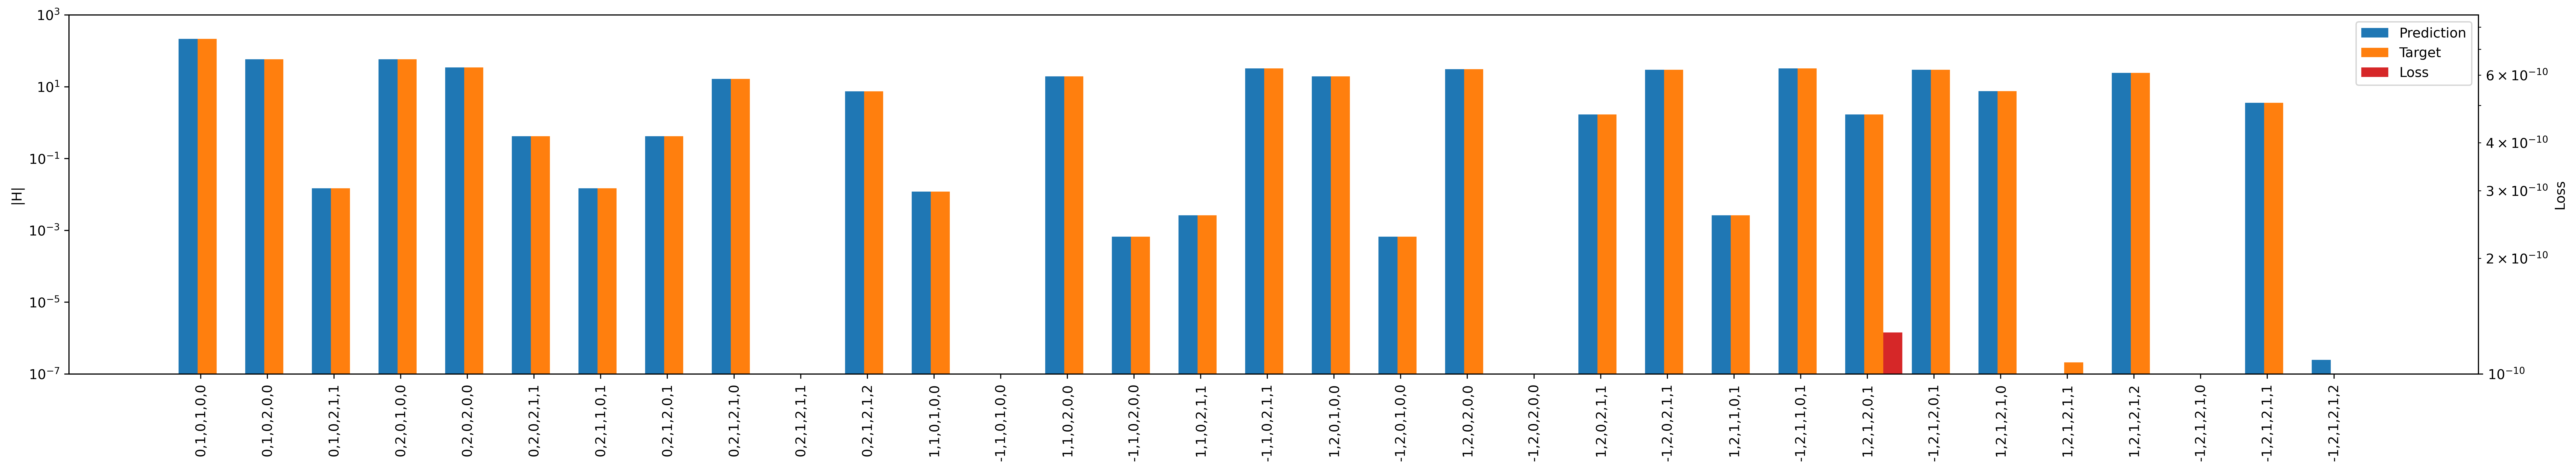

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 500
x=[','.join([str(lbl[i]) for i in [0,2,3,5,6,7]]) for lbl in target_coupled_blocks['hex'].keys.values.tolist()]
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*5, fs[1]))
ax_loss = ax.twinx()
# s = (0,0,0)
prediction_ = np.array([torch.linalg.norm(b.values) for b in pred_ridge_bias])
target_ = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['hex']])
loss_ = np.array([torch.linalg.norm(b.values-b1.values)**2 for b,b1 in zip(target_coupled_blocks['hex'],pred_ridge_bias)])
print(np.sum(loss_))
# loss_ = np.array(list(loss_blocks.values()))
#MASKING LOSS
# mask = loss_ < 1e-6
# loss_[mask] = 0
# ax.bar(range(len(loss_blocks.keys())),list(loss_blocks.values()));

x_ = 3.5*np.arange(len(loss_blocks))

labels = []
handles = []
pl = ax.bar(x_, prediction_, label = 'pred', width = 1, color = 'tab:blue');
handles.append(pl)
labels.append('Prediction')
pl = ax.bar(x_+1, target_, alpha = 1, label = 'target', width = 1, color = 'tab:orange');
handles.append(pl)
labels.append('Target')

pl = ax_loss.bar(x_+2, loss_, alpha = 1, label = 'target', width = 1, color = 'tab:red');
handles.append(pl)
labels.append('Loss')

ax.set_ylim(1e-7, 1000)
ax.set_xticks(3.5*np.arange(len(loss_blocks))+3.5/3-0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(handles, labels, loc = 'best')
ax.set_ylabel('|H|')
ax_loss.set_ylabel('Loss')
ax_loss.set_yscale('log')
ax_loss.set_ylim(1e-10)
ax.set_yscale('log')

In [90]:
# fig.savefig(results_C2_rotated_881)

## USE the model trained on HEX to predict HEX22

In [68]:
model_ridge_hex22 = LinearModelPeriodic(twocfeat=hfeat_tc['hex22'], target_blocks=target_coupled_blocks['double_hex'], frames = dataset['double_hex'].structures, orbitals= dataset['double_hex'].basis, cell_shifts=dataset['double_hex'].desired_shifts[:], device = device)


cpu
[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [1 0 0]
 [1 1 0]
 [1 2 0]
 [1 3 0]
 [2 0 0]
 [2 1 0]
 [2 2 0]
 [2 3 0]
 [3 0 0]
 [3 1 0]
 [3 2 0]
 [3 3 0]] 16


In [69]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
device= "cpu"
pred_hex22_blocks = []
dummy_property = target_coupled_blocks['double_hex'][0].properties
targetkeynames = target_coupled_blocks['double_hex'].keys.names
for imdl, (key, tkey) in enumerate(zip(model_ridge_hex22.model,target_coupled_blocks['double_hex'].keys )):
    # k = Labels( targetkeynames, values =np.array(eval(key)).reshape(1,-1))
    target = target_coupled_blocks['double_hex'].block(tkey)
    nsamples, ncomp, nprops = target.values.shape
    
    feat = map_targetkeys_to_featkeys(hfeat_tc['hex22'], tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = ridges_bias[imdl].predict(x)
    pred_hex22_blocks.append(
                    TensorBlock(
                        values=torch.from_numpy(pred.reshape((nsamples, ncomp, 1)))
                        .to(device)
                        .to(torch.float32),
                        samples=target.samples,
                        components=target.components,
                        properties=dummy_property,
                    )
                )


In [70]:
pred_hex22 = TensorMap(target_coupled_blocks['double_hex'].keys, pred_hex22_blocks)

In [71]:
loss = {}
for k, tb in target_coupled_blocks['double_hex'].items():
    loss[tuple(k)]= torch.norm(tb.values - pred_hex22.block(k).values/2)**2 

In [72]:
print(loss)

{(0, 6, 1, 0, 6, 1, 0, 0): tensor(2.9104e-07), (0, 6, 1, 0, 6, 2, 0, 0): tensor(6.5484e-09), (0, 6, 1, 0, 6, 2, 1, 1): tensor(6.6068e-15), (0, 6, 2, 0, 6, 1, 0, 0): tensor(6.5484e-09), (0, 6, 2, 0, 6, 2, 0, 0): tensor(2.6683e-07), (0, 6, 2, 0, 6, 2, 1, 1): tensor(6.9327e-16), (0, 6, 2, 1, 6, 1, 0, 1): tensor(6.6068e-15), (0, 6, 2, 1, 6, 2, 0, 1): tensor(6.9327e-16), (0, 6, 2, 1, 6, 2, 1, 0): tensor(3.8364e-07), (0, 6, 2, 1, 6, 2, 1, 1): tensor(5.4385e-31), (0, 6, 2, 1, 6, 2, 1, 2): tensor(1.6762e-07), (1, 6, 1, 0, 6, 1, 0, 0): tensor(2.2669e-08), (-1, 6, 1, 0, 6, 1, 0, 0): tensor(1.3465e-26), (1, 6, 1, 0, 6, 2, 0, 0): tensor(1.1666e-08), (-1, 6, 1, 0, 6, 2, 0, 0): tensor(2.0452e-11), (1, 6, 1, 0, 6, 2, 1, 1): tensor(3.3380e-10), (-1, 6, 1, 0, 6, 2, 1, 1): tensor(9.9773e-08), (1, 6, 2, 0, 6, 1, 0, 0): tensor(1.1666e-08), (-1, 6, 2, 0, 6, 1, 0, 0): tensor(2.0452e-11), (1, 6, 2, 0, 6, 2, 0, 0): tensor(6.2611e-06), (-1, 6, 2, 0, 6, 2, 0, 0): tensor(3.8707e-28), (1, 6, 2, 0, 6, 2, 1, 1): te

In [75]:
print(sum(loss.values()))

tensor(5.0290e-05)


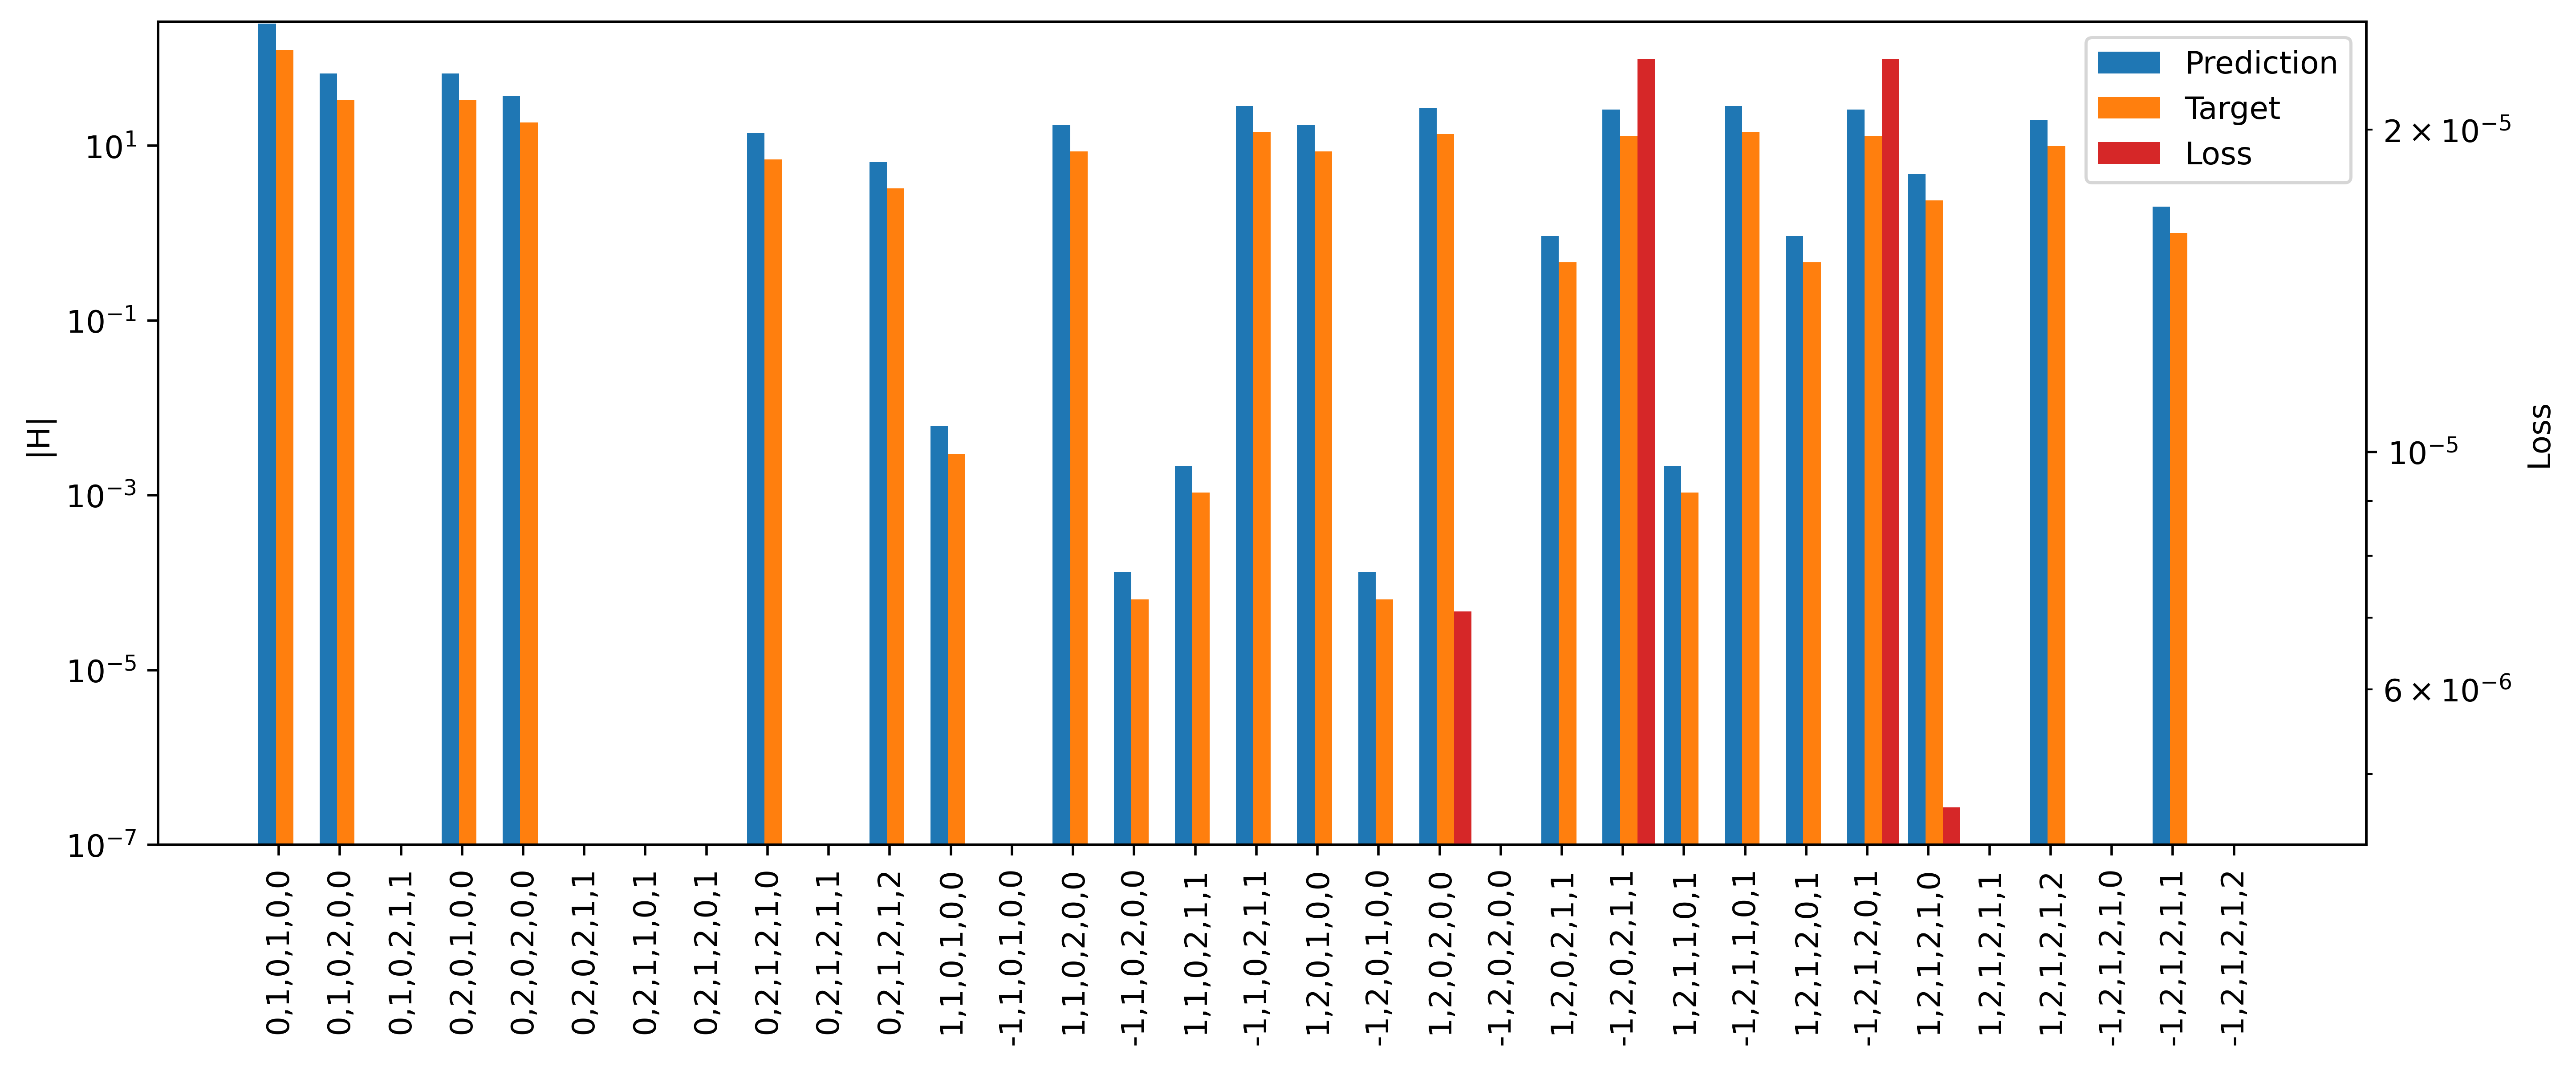

In [77]:
#HEX22
import matplotlib.pyplot as plt
x=[','.join([str(lbl[i]) for i in [0,2,3,5,6,7]]) for lbl in target_coupled_blocks['hex'].keys.values.tolist()]
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))
ax_loss = ax.twinx()
# s = (0,0,0)
prediction_ = np.array([torch.linalg.norm(b.values) for b in pred_hex22])
target_ = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['double_hex']])
loss_ = np.array(list(loss_blocks.values()))
#MASKING LOSS
mask = loss_ < 1e-6
loss_[mask] = 0

# ax.bar(range(len(loss_blocks.keys())),list(loss_blocks.values()));

x_ = 3.5*np.arange(len(loss_blocks))

labels = []
handles = []
pl = ax.bar(x_, prediction_, label = 'pred', width = 1, color = 'tab:blue');
handles.append(pl)
labels.append('Prediction')
pl = ax.bar(x_+1, target_, alpha = 1, label = 'target', width = 1, color = 'tab:orange');
handles.append(pl)
labels.append('Target')

pl = ax_loss.bar(x_+2, loss_, alpha = 1, label = 'target', width = 1, color = 'tab:red');
handles.append(pl)
labels.append('Loss')

ax.set_xticks(3.5*np.arange(len(loss_blocks))+3.5/3-0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(handles, labels, loc = 'best')
ax.set_ylabel('|H|')
ax_loss.set_ylabel('Loss')
ax_loss.set_yscale('log')
ax.set_ylim(1e-7)
# ax_loss.set_ylim(2e-6, 9.9e-2)
ax.set_yscale('log')

## Translation wise predictions

In [54]:
def get_translation_wise_blocks(pred, dataset):
    recon_blocks = {}
    for translation in dataset.desired_shifts:
        block_keys = []
        blocks = []
        for key, block in pred.items():
                # TODO: replace labels_where
                try:
                    _, i = labels_where(
                        block.samples,
                        Labels(
                            ["cell_shift_a", "cell_shift_b", "cell_shift_c"],
                            values=np.asarray(
                                [translation[0], translation[1], translation[2]]
                            ).reshape(1, -1),
                        ),
                        return_idx=True,
                    )
                except:
    #                 print("{} not found in {}".format(translation, key))
                    if key["block_type"]>0:
                        raise ValueError("block type other than 0 missing")
                    continue
                block_keys.append(key.values)
                blocks.append(
                    TensorBlock(
                        samples=Labels(
                            pred.sample_names[:-3],
                            values=np.asarray(block.samples.values[i])[:, :-3],
                        ),
                        values=block.values[i],
                        components=block.components,
                        properties=block.properties,
                    )
                )
        tmap = TensorMap(Labels(pred.keys.names,np.asarray(block_keys)), blocks)
        recon_blocks[tuple(translation)] = tmap

    return recon_blocks


In [55]:
#GIJ 
# gij = get_translation_wise_blocks(gij, dataset['hex'])
# for k, b in gij[(5,4,0)].items():
#     print(torch.linalg.norm(b.values), torch.linalg.norm(gij[(1,2,0)].block(k).values))

In [56]:
feat_blocks = get_translation_wise_blocks(hfeat_tc['hex'], dataset['hex'])

In [57]:
recon_blocks = get_translation_wise_blocks(pred_ridge_bias, dataset['hex'])
actual_blocks = get_translation_wise_blocks(target_coupled_blocks['hex'], dataset['hex'])

In [59]:
losses = {tuple(t):{} for t in dataset['hex'].desired_shifts}
pred = {tuple(t):{} for t in dataset['hex'].desired_shifts}
for t in losses.keys():
    for k,b in recon_blocks[tuple(t)].items():
        losses[t][tuple(k.values)] = torch.sum((b.values - actual_blocks[t].block(k).values )**2)
        
loss_translation = {}
for t in losses.keys():
    loss = 0
    for k,v in losses[t].items():
        loss+=v
    loss_translation[t] = loss

In [60]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
losses_550 = losses[(3,3,0)]
losses_110 = losses[(1,1,0)]
key_names =actual_blocks[(0,0,0)].keys.names
for k,v in losses_110.items():
    target_key = Labels(key_names, np.asarray(k).reshape(1,-1))
    targetblock110 = actual_blocks[(1,1,0)].block(target_key)
    targetblock550 = actual_blocks[(3,3,0)].block(Labels(key_names, np.asarray(k).reshape(1,-1)))
    feat_key = map_targetkeys_to_featkeys(hfeat_tc['hex'], target_key, return_key=True)

    featblock110 = feat_blocks[(1,1,0)].block(feat_key)
    featblock550 = feat_blocks[(3,3,0)].block(feat_key)
    
    print(f'{k} {v:.3e} {losses_550[k]:.3e} {np.linalg.norm(targetblock110.values):.3e} {np.linalg.norm(targetblock550.values):.3e} {np.linalg.norm(featblock110.values):.3e} {np.linalg.norm(featblock550.values):.3e}')
#     print("TARGET", recon_blocks[(5,5,0)].block )


(1, 6, 1, 0, 6, 1, 0, 0) 3.365e-18 1.844e-18 2.467e-06 1.202e-07 1.516e+00 6.224e-01
(-1, 6, 1, 0, 6, 1, 0, 0) 1.999e-27 5.691e-27 4.470e-14 7.544e-14 8.891e-01 3.427e-01
(1, 6, 1, 0, 6, 2, 0, 0) 1.108e-18 6.755e-19 5.965e-05 1.780e-06 1.516e+00 6.224e-01
(-1, 6, 1, 0, 6, 2, 0, 0) 1.944e-19 8.823e-22 3.856e-05 9.744e-08 8.891e-01 3.427e-01
(1, 6, 1, 0, 6, 2, 1, 1) 3.705e-17 1.145e-17 8.978e-05 2.721e-06 1.330e+00 5.378e-01
(-1, 6, 1, 0, 6, 2, 1, 1) 8.859e-15 1.515e-12 1.613e-05 1.368e-06 2.508e+00 1.071e+00
(1, 6, 2, 0, 6, 1, 0, 0) 1.108e-18 6.755e-19 5.965e-05 1.780e-06 1.516e+00 6.224e-01
(-1, 6, 2, 0, 6, 1, 0, 0) 1.974e-19 8.885e-22 3.856e-05 9.744e-08 8.891e-01 3.427e-01
(1, 6, 2, 0, 6, 2, 0, 0) 3.945e-17 4.266e-18 2.013e-02 8.455e-06 1.516e+00 6.224e-01
(-1, 6, 2, 0, 6, 2, 0, 0) 6.356e-29 1.065e-28 8.076e-15 1.023e-14 8.891e-01 3.427e-01
(1, 6, 2, 0, 6, 2, 1, 1) 2.082e-18 4.319e-20 1.594e-03 2.558e-05 1.330e+00 5.378e-01
(-1, 6, 2, 0, 6, 2, 1, 1) 2.105e-07 1.431e-07 4.033e-02 2.10

In [61]:
for t in loss_translation.keys():
    print(t,loss_translation[t], np.linalg.norm(dataset['hex'].matrices_translation[t]))

(0, 0, 0) tensor(2.2635e-07) 136.3651004240648
(0, 1, 0) tensor(1.5524e-08) 13.976655281143573
(0, 2, 0) tensor(6.6781e-07) 0.2158549195156131
(0, 3, 0) tensor(2.5152e-06) 0.009422931891761861
(0, 4, 0) tensor(4.3165e-06) 0.0062545510153280935
(0, 5, 0) tensor(1.9534e-06) 0.009422931891761997
(0, 6, 0) tensor(3.5230e-07) 0.21585491951561891
(0, 7, 0) tensor(2.3908e-07) 13.976655281143575
(1, 0, 0) tensor(1.5524e-08) 13.976655281031444
(1, 1, 0) tensor(4.3429e-07) 1.0315519623865441
(1, 2, 0) tensor(6.1139e-07) 0.025737135809518148
(1, 3, 0) tensor(5.0767e-07) 0.0028679693380460943
(1, 4, 0) tensor(3.6304e-07) 0.00757676496596472
(1, 5, 0) tensor(5.6076e-07) 0.014679827153324563
(1, 6, 0) tensor(1.6262e-07) 0.22807713532044063
(1, 7, 0) tensor(1.3684e-08) 3.9714871724738545
(2, 0, 0) tensor(6.6781e-07) 0.21585491908295712
(2, 1, 0) tensor(6.1139e-07) 0.025737135808400775
(2, 2, 0) tensor(1.6413e-06) 0.017034647409539156
(2, 3, 0) tensor(1.2890e-06) 0.006788033322623809
(2, 4, 0) tensor(

In [43]:
x=[','.join([str(lbl[i]) for i in [0,2,3,5,6,7]]) for lbl in target_coupled_blocks['hex'].keys.values.tolist()]

Text(0.5, 1.0, 'Loss per block')

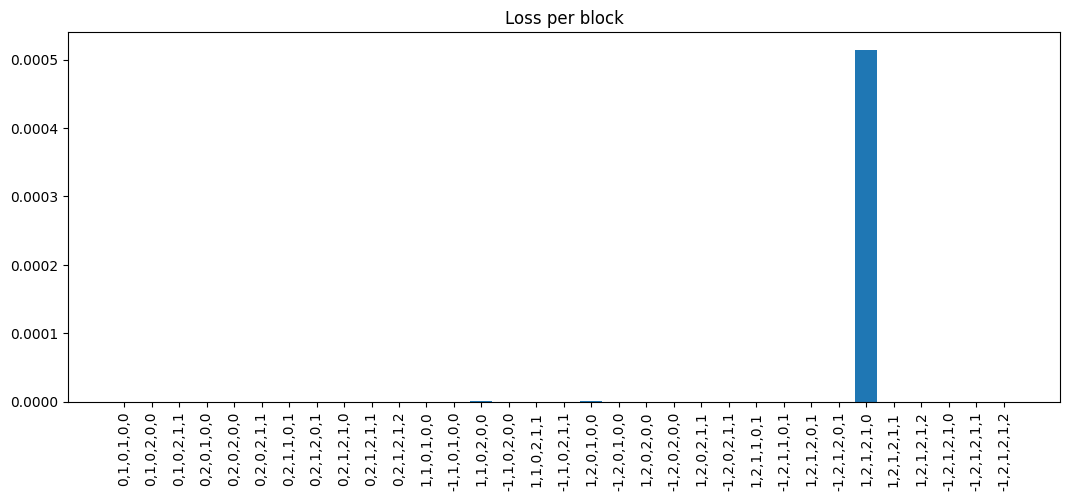

In [44]:
import matplotlib.pyplot as plt
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))# s = (0,2,0)

ax.bar(range(len(loss_blocks.keys())),list(loss_blocks.values()));
ax.set_xticks(np.arange(len(loss_blocks.keys())))
ax.set_xticklabels(x, rotation=90);
ax.set_title('Loss per block')

In [133]:
target_coupled_blocks['hex'].block(lbl).values.shape

torch.Size([106, 3, 1])

In [145]:
# lbl = Labels(pred_ridge_bias.keys.names, np.array([-1,6,1,0,6,2,1,1]).reshape(1,-1))
lbl = Labels(pred_ridge_bias.keys.names, np.array([1,6,1,0,6,2,0,0]).reshape(1,-1))

for p, t in zip(pred_ridge_bias.block(lbl).values, target_coupled_blocks['hex'].block(lbl).values):
    for v1, v2, in zip(t, p):
        print(v1, v2)
    print('')
print('err',torch.linalg.norm(pred_ridge_bias.block(lbl).values-target_coupled_blocks['hex'].block(lbl).values)**2)

tensor([-0.1691]) tensor([-0.1703])

tensor([-0.0005]) tensor([0.0003])

tensor([0.0002]) tensor([0.0006])

tensor([-0.0005]) tensor([0.0003])

tensor([-0.1691]) tensor([-0.1703])

tensor([-0.1691]) tensor([-0.1703])

tensor([0.0002]) tensor([-0.0006])

tensor([0.0002]) tensor([0.0002])

tensor([0.0002]) tensor([0.0002])

tensor([0.0002]) tensor([-0.0006])

tensor([-0.1690]) tensor([-0.1703])

tensor([-0.0005]) tensor([0.0003])

tensor([0.0002]) tensor([0.0002])

tensor([2.5860e-05]) tensor([-0.0003])

tensor([0.0002]) tensor([0.0002])

tensor([-0.0005]) tensor([0.0003])

tensor([0.0002]) tensor([-0.0006])

tensor([0.0002]) tensor([0.0006])

tensor([0.0002]) tensor([0.0002])

tensor([0.0002]) tensor([0.0002])

tensor([0.0002]) tensor([0.0006])

tensor([0.0002]) tensor([0.0002])

tensor([0.0002]) tensor([0.0002])

tensor([-0.0005]) tensor([0.0003])

tensor([0.0002]) tensor([-0.0006])

tensor([-0.0005]) tensor([0.0003])

tensor([0.0002]) tensor([0.0002])

tensor([2.5860e-05]) tensor([-0.

In [ ]:
import matplotlib.pyplot as plt
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))
# s = (0,0,0)
y = np.array([torch.linalg.norm(b.values) for b in pred_ridge_bias])
yt = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['hex']])
x_ = 2.5*np.arange(len(loss_blocks))
ax.bar(x_, y, label = 'pred', width = 1);
ax.bar(x_+1, yt, alpha = 1, label = 'target', width = 1);

ax.set_xticks(2.5*np.arange(len(loss_blocks))+0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(loc = 'upper left')

In [ ]:
block_type = 1; inversion_sigma = 1; L = 0
# lbl = Labels(["block_type", "inversion_sigma"], values = np.asarray([block_type, inversion_sigma]).reshape(1,-1))
np.argwhere(np.all(np.array(hfeat_tc['hex'].keys.view(["block_type", "inversion_sigma", "spherical_harmonics_l"]))== np.array([block_type, inversion_sigma,L]), axis=1))

In [45]:
block_type = 1; inversion_sigma = 1; L = 0
# lbl = Labels(["block_type", "inversion_sigma"], values = np.asarray([block_type, inversion_sigma]).reshape(1,-1))
np.argwhere(np.all(np.array(hfeat_tc['hex'].keys.view(["block_type", "inversion_sigma", "spherical_harmonics_l"]))== np.array([block_type, inversion_sigma,L]), axis=1))

array([[8]])

In [ ]:
features_per_translation = model_ridge.model_return(hfeat_hexpca)#['hex'])

In [ ]:
# for 
# ridges_bias[0].coef_.shape


In [35]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
# s = (2,0,0)
featblock_norm =[]
for iblock, (k, _) in enumerate(target_coupled_blocks['hex'].items()):
    featkey = map_targetkeys_to_featkeys(features_per_translation, k, return_key=True)
    
    relevant_feat = np.where(np.abs(ridges_bias[iblock].coef_.flatten()) >1e-8)
#     print(k.values,relevant_feat[0].shape)
    featblock = hfeat['hex'].block(featkey)
    featblock_norm.append(torch.linalg.norm(featblock.values[...,relevant_feat]))
    

NameError: name 'features_per_translation' is not defined

In [ ]:
import matplotlib.pyplot as plt
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))
# s = (0,0,0)
ax2 = ax.twinx()
y = np.array([torch.linalg.norm(b.values) for b in pred_ridge_bias[s]])
yt = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['hex'][s]])
f = np.array(featblock_norm)

x_ = 2.5*np.arange(len(ridge_block_losses[s]))
ax.bar(x_, yt, label = 'pred', width = 1);
# ax.bar(x_+1, yt, alpha = 1, label = 'target', width = 1);
ax2.bar(x_+1, f, alpha = 1, label = 'feature', width = 1, color = 'tab:orange');

ax.set_xticks(2.5*np.arange(len(ridge_block_losses[s]))+0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(loc = 'upper left')
ax2.legend(loc = 'center left')

In [ ]:
plt.plot(f/f.max(), y/y.max(), 'o')

## Plot bands

In [ ]:
# def compute_Hk(Ht, St, t, k_point):
#     phases = np.exp(1j*t @ k_point)
#     H = np.einsum("nij, n -> ij", Ht, phases)
#     S = np.einsum("nij, n -> ij", St, phases)
#     return H, S

# Ht =  np.asarray(list(dataset['hex'].matrices_translation.values()))[:,0]
# St =  np.asarray(list(dataset['hex'].overlap_translation.values()))[:,0]

# inverse_cell = frame.cell.reciprocal()*2*np.pi
# superframecell = frame.repeat(kmesh).cell
# framecell= frame.cell
# cell_inv = np.linalg.inv(superframecell)
# supercell = frame.repeat(kmesh).positions
# # get the relative dispalcement vector from the first atom in translated cell
# R_list = np.array([ supercell[i]-supercell[0] for i in range(0, len(supercell), len(frame)) ])
# # S_list = R_list @ cell_inv  # relative trans
# # S_list -= np.round(S_list) # wrapped within cell - MIC
# R_list = S_list @ superframecell # convert back to absolute dist
# eva = []
# qgrid = np.linspace(0,0.5,50)
# kgrid = [cell_inv[0] * x for x in qgrid]

# # kgrid = kpts_pyscf
# for k in kgrid:
    
#     Hk, Sk = compute_Hk(Ht, St, R_list, k)
#     eva.append(scipy.linalg.eigvalsh(Hk, Sk)*27.2)
#     print(np.linalg.norm(Hk - Hk.T.conj()))
# eva = np.array(eva)
# for i in range(eva.shape[1]):
#     # plt.plot(xcoords, eva[:,i])
#     plt.plot(qgrid, eva[:,i])
# # for p in special_xcoords:
# #     plt.plot([p, p], [emin, emax], 'k-')
# # plt.plot([0, sp_points[-1]], [0, 0], 'k-')
# # plt.xticks(x, labels)
# # plt.xticks(special_xcoords, labels)# ['$%s$' % n for n in [r'\Gamma', 'M', 'K', r'\Gamma']])
# # plt.axis(xmin=0, xmax=special_xcoords[-1], ymin=emin, ymax=emax)
# # plt.xlabel('k-vector')
# plt.ylim(-15,40)